# Final Project Submission

Please fill out:
* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header.*<br><br>
 
- **[INTRODUCTION](#Introduction)<br>**
- **[OBTAIN](#Obtain)**<br>
- **[SCRUB](#Scrub)**<br>
- **[EXPLORE](#Explore)**<br>
- **[MODEL](#Model)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# Introduction

## Business Statement

Most people's largest asset is their home which acts as the foundation for their net worth. Therefore, it is imperative that the value of this asset improves over time through either property value inflation or smart renovations. Since property values are largely based on location and current market conditions, which are outside of your control, renovations are the only controllable factor when trying to improve a homes value. In this analysis, I will explore which factors in a house are most correlated to higher value by looking at historical sales of homes in King County, Washington.

## Analysis Methodology

I will be analyzing historic home sales from King County, Washington in order to see which factors affect home price and how a model can be built to predict good estimates for home listing prices. This model will give insights into what a current home owner could do in order to improve their home value. I will focus only on features which a home owner has control over and eliminate the others.

# Obtain

## Import Packages

In [892]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [893]:
pd.set_option("display.max_columns", 30)
pd.options.display.float_format = '{:,}'.format

## Global Functions

In [894]:
#function to look at plots and stats of column with or without outliers
def get_plots(df, x_col, y_col='price', outlier='std'):
    
    """This function takes in a dataframe and a column, removes outliers using
       standard deviations or iqr and produces a histogram, scatter plot and
       boxplot of the values with descriptive statistics"""
    
    #plots for std
    if outlier == 'std':
        #create variables
        col_mean = df[x_col].mean()
        col_std = df[x_col].std()
        upper_thresh_std = col_mean + 3*col_std
        lower_thresh_std = col_mean - 3*col_std
        
        #create new df
        idx_std_outliers = (df[x_col] > lower_thresh_std) & (df[x_col] < upper_thresh_std)
        std_df = df.loc[idx_std_outliers]
        
        #plots
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = std_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = std_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = std_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(std_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        #stats
        rows_removed = len(df) - len(std_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = std_df[x_col].describe()
        plt.tight_layout()
        
    elif outlier == 'iqr':
        #create variables
        q25 = df[x_col].quantile(0.25)
        q75 = df[x_col].quantile(0.75)
        iqr = q75-q25
        upper_thresh_iqr = q75 + 1.5*iqr
        lower_thresh_iqr = q25 - 1.5*iqr
        
        #create new df
        idx_iqr_outliers = (df[x_col] > lower_thresh_iqr) & (df[x_col] < upper_thresh_iqr)
        iqr_df = df.loc[idx_iqr_outliers]
        
        #plots
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = iqr_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = iqr_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = iqr_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(iqr_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        #stats
        rows_removed = len(df) - len(iqr_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = df[x_col].describe()
        plt.tight_layout()
    
    elif outlier == 'none':
        #plots
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');

        sm.graphics.qqplot(df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        #stats
        desc_stats = df[x_col].describe()
        plt.tight_layout()

        
    print(desc_stats)
    plt.show()
    
    return
#     return histogram, scatter, boxplot, desc_stats, idx_iqr_outliers

In [895]:
#function to preprocess and create a new model
def fit_new_model(df, x_cols=None, y_col=None, norm=False, diagnose=True):
    '''This function takes in a dataframe, a list of independent and dependent
       variables and whether or not you want to normalize the columns. The 
       output is a multiple linear regression model with checks for 
       multicollinearity, normality and homoscedasticity.'''
         
    #step 1: normalize columns
    if norm == True:
        for col in x_cols:
            df[col] = (df[col] - df[col].mean())/df[col].std()
        #display the normalized df
        display(df.head())
        print('\n')
    else:
        #display the df
        display(df.head())
        print('\n')
    
    #step 2: create model
    
    #set up model parameters
    x_cols = x_cols
    outcome = y_col
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    #fit the model
    model = ols(formula=formula, data=df).fit()
    print(model.summary())
    print('\n')
    
    #step 3: check multicollinearity
    print('VIF Multicollinearity Test Results')
    print('======================================================================================================')
    #run VIF test
    X = df[x_cols]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    display(list(zip(x_cols, vif)))
    print('\n')
    
    #step 4: check normality
    print('Normality Test Results')
    print('======================================================================================================')
    #plot qqplot
    fig, ax = plt.subplots(figsize=(15,10))
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax);
    ax.set_title('QQPlot for Model Residuals')
    plt.show()
    print('\n')
    
    #step 5: check homoscedasticity
    print('Homoscedasticity Test Results')
    print('======================================================================================================')
    #scatter plot
    fig, ax = plt.subplots(figsize=(15,10))
    plt.scatter(model.predict(df[x_cols]), model.resid)
    plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])
    ax.set_title('Model Residuals vs Model Predictions')
    plt.show()
    return model

In [896]:
#function to delete outliers using either iqr or std
def outliers(df, col, outlier='std'):
    '''This function takes in a dataframe, a column in the dataframe and 
       whether or not to remove outliers via standard deviations or
       interquartile range.'''
        
    if outlier == 'std':
        #create outlier variables
        col_mean = df[col].mean()
        col_std = df[col].std()
        upper_thresh_std = col_mean + 3*col_std
        lower_thresh_std = col_mean - 3*col_std
        #update dataframe
        df_new = df.loc[(df[col] > lower_thresh_std) & (df[col] < upper_thresh_std)]
        print(f'There were {len(df) - len(df_new)} outliers removed.')
    elif outlier == 'iqr':
        #create outlier variables
        q25 = df[col].quantile(0.25)
        q75 = df[col].quantile(0.75)
        iqr = q75-q25
        upper_thresh_iqr = q75 + 1.5*iqr
        lower_thresh_iqr = q25 - 1.5*iqr
        #create new dataframe with outliers removed
        df_new = df.loc[(df[col] > lower_thresh_iqr) & (df[col] < upper_thresh_iqr)]
        print(f'There were {len(df) - len(df_new)} outliers removed.')

    return df_new

## Import Data into Pandas

I will be importing a csv dataset which provides me with the information necessary to begin the analysis.

In [897]:
#import the dataset from local csv
df_original = pd.read_csv('Data/kc_house_data.csv')
df_original

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Data Schema

**Taken from https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html**

id - Unique ID for each home sold 

date - Date of the home sale 

price - Price of each home sold 

bedrooms - Number of bedrooms 

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower 

sqft_living - Square footage of the apartments interior living space 

sqft_lot - Square footage of the land space 

floors - Number of floors 

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not 

view - An index from 0 to 4 of how good the view of the property was 

condition - An index from 1 to 5 on the condition of the home

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. 

sqft_above - The square footage of the interior housing space that is above ground level 

sqft_basement - The square footage of the interior housing space that is below ground level 

yr_built - The year the house was initially built 

yr_renovated - The year of the house’s last renovation 

zipcode - What zipcode area the house is in 

lat - Lattitude 

long - Longitude 

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors 

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors 

## Investigate Data

I will preliminarily investigate the data to identify any glaring issues to fix later.

In [898]:
#column names
df_original.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [899]:
#view df info to inspect data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

> **Observations on Data**
> - `waterfront` values should be updated to a binary categorical data type
> - `yr_renovated` values should be updated to binary categorical data type
> - `sqft_basement` values should be updated to a binary categorical data type

In [900]:
#check for null values
df_original.isna().sum()/len(df_original)*100

id                              0.0
date                            0.0
price                           0.0
bedrooms                        0.0
bathrooms                       0.0
sqft_living                     0.0
sqft_lot                        0.0
floors                          0.0
waterfront        11.00152798999861
view            0.29170718155299347
condition                       0.0
grade                           0.0
sqft_above                      0.0
sqft_basement                   0.0
yr_built                        0.0
yr_renovated      17.78950780200954
zipcode                         0.0
lat                             0.0
long                            0.0
sqft_living15                   0.0
sqft_lot15                      0.0
dtype: float64

> **Observations on Data**
> - `waterfront` has 11% null values which is a large number to simply drop. Will evaluate options.
> - `view` should be explored further to see what it means
> - `yr_renovated` has 18% null values which is a large number to simply drop. Will evaluate options.
> - All other columns have 0 nulls

In [901]:
#check numeric data
df_original.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","19,221.0","21,534.0","21,597.0","21,597.0","21,597.0","21,597.0","17,755.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0"
mean,"4,580,474,287.770987","540,296.5735055795",3.3731999814789093,2.1158262721674306,"2,080.3218502569803","15,099.408760475992",1.4940964022780943,0.007595858696217679,0.23386272870808952,3.4098254387183404,7.657915451220076,"1,788.5968421540028","1,970.9996758809093",83.6367783722895,"98,077.95184516368",47.56009299439737,-122.2139824975691,"1,986.6203176367087","12,758.283511598833"
std,"2,876,735,715.74778","367,368.1401013945",0.9262988945421479,0.7689842966527209,918.1061250800805,"41,412.636875502074",0.5396827909775457,0.08682484570054606,0.7656862011746727,0.6505456356725546,1.1731996637760254,827.7597611646754,29.375234132441644,399.9464138788162,53.51307235352816,0.13855176817307177,0.14072352882947373,685.2304719001586,"27,274.441950386343"
min,"1,000,102.0","78,000.0",1.0,0.5,370.0,520.0,1.0,0.0,0.0,1.0,3.0,370.0,"1,900.0",0.0,"98,001.0",47.1559,-122.51899999999999,399.0,651.0
25%,"2,123,049,175.0","322,000.0",3.0,1.75,"1,430.0","5,040.0",1.0,0.0,0.0,3.0,7.0,"1,190.0","1,951.0",0.0,"98,033.0",47.4711,-122.32799999999999,"1,490.0","5,100.0"
50%,"3,904,930,410.0","450,000.0",3.0,2.25,"1,910.0","7,618.0",1.5,0.0,0.0,3.0,7.0,"1,560.0","1,975.0",0.0,"98,065.0",47.5718,-122.23100000000001,"1,840.0","7,620.0"
75%,"7,308,900,490.0","645,000.0",4.0,2.5,"2,550.0","10,685.0",2.0,0.0,0.0,4.0,8.0,"2,210.0","1,997.0",0.0,"98,118.0",47.678000000000004,-122.125,"2,360.0","10,083.0"
max,"9,900,000,190.0","7,700,000.0",33.0,8.0,"13,540.0","1,651,359.0",3.5,1.0,4.0,5.0,13.0,"9,410.0","2,015.0","2,015.0","98,199.0",47.7776,-121.315,"6,210.0","871,200.0"


# Scrub

I will make a new dataframe which is a copy of the `df_original` dataframe to begin making changes. 

In [902]:
#create a copy of the original dataframe
df_scrub = df_original.copy()
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Feature Engineering

### `basement` Column

In the dataset we have 3 related columns:
- `sqft_above`
- `sqft_basement`
- `sqft_living`

These columns are related in that `sqft_living` equals `sqft_above` plus `sqft_basement`. I do not think the square footage of the basement is as important as just knowing that a house has one. Therefore, I will create a new column which shows whether or not a house has a basement.

In [903]:
#investigate values in sqft_basement
display(df_scrub['sqft_basement'].value_counts(),len(df_scrub), df_scrub['sqft_basement'].dtype)

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
         ...  
768.0        1
276.0        1
556.0        1
65.0         1
508.0        1
Name: sqft_basement, Length: 304, dtype: int64

21597

dtype('O')

> **ACTIONS**
> - '?' impedes the ability to create a new column. Will drop convert this to a 0 to indicate that the house does not have a basement.

In [904]:
#convert rows with a '?' to a 0
df_scrub.loc[df_scrub['sqft_basement'] == '?', ['sqft_basement']] = '0.0'
display(df_scrub['sqft_basement'].value_counts(),len(df_scrub))

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
784.0         1
2390.0        1
915.0         1
768.0         1
2360.0        1
Name: sqft_basement, Length: 303, dtype: int64

21597

In [905]:
#prove that these columns are related
df_scrub['sqft_basement'] = df_scrub['sqft_basement'].astype(float).astype(int)
sqft = df_scrub[['sqft_living', 'sqft_above', 'sqft_basement']]
(sqft['sqft_above'] + sqft['sqft_basement'] == sqft['sqft_living']).value_counts()

True     21427
False      170
dtype: int64

In [906]:
#investigate the Falses
df_scrub.loc[(sqft['sqft_above'] + sqft['sqft_basement'] == sqft['sqft_living']) == False]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
112,2525310310,9/16/2014,"272,500.0",3,1.75,1540,12600,1.0,0.0,0.0,4,7,1160,0,1980,0.0,98038,47.3624,-122.031,1540,11656
115,3626039325,11/21/2014,"740,500.0",3,3.5,4380,6350,2.0,0.0,0.0,3,8,2780,0,1900,nan,98117,47.6981,-122.368,1830,6350
309,3204800200,1/8/2015,"665,000.0",4,2.75,3320,10574,2.0,nan,0.0,5,8,2220,0,1960,0.0,98056,47.5376,-122.18,2720,8330
384,713500030,7/28/2014,"1,350,000.0",5,3.5,4800,14984,2.0,0.0,2.0,3,11,3480,0,1998,0.0,98006,47.5543,-122.148,4050,19009
508,5113400431,5/8/2014,"615,000.0",2,1.0,1540,6872,1.0,0.0,0.0,4,7,820,0,1946,0.0,98119,47.6454,-122.37299999999999,1420,5538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21000,291310180,6/13/2014,"379,500.0",3,2.25,1410,1287,2.0,0.0,0.0,3,7,1290,0,2005,0.0,98027,47.5344,-122.068,1490,1435
21109,3438500250,6/23/2014,"515,000.0",5,3.25,2910,5027,2.0,0.0,0.0,3,8,2040,0,2013,0.0,98106,47.5543,-122.359,2910,5027
21210,3278600680,6/27/2014,"235,000.0",1,1.5,1170,1456,2.0,0.0,0.0,3,8,1070,0,2007,0.0,98126,47.5493,-122.37200000000001,1360,1730
21356,6169901185,5/20/2014,"490,000.0",5,3.5,4460,2975,3.0,0.0,2.0,3,10,3280,0,2015,nan,98119,47.6313,-122.37,2490,4231


>**OBSERVATIONS**
> - It seems that 170 homes have a difference between the `sqft_living` and `sqft_above` that were originially classified as a '?'.

>**ACTIONS**
> - I will now assume that the difference in these 170 homes is due to having sq_ft in the basement. I will change from a 0 to the difference in `sqft_living` and `sqft_above`

In [907]:
#replace sqft_basement with the desscrepency between sqft_living and sqft_above
df_scrub['sqft_basement'] = df_scrub['sqft_living']- df_scrub['sqft_above']
display(df_scrub['sqft_basement'].value_counts(), len(df_scrub))

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

21597

In [908]:
#check previous id where sqft_basement was a '?'
df_scrub.loc[df_scrub['id'] == 2525310310]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
112,2525310310,9/16/2014,"272,500.0",3,1.75,1540,12600,1.0,0.0,0.0,4,7,1160,380,1980,0.0,98038,47.3624,-122.031,1540,11656


In [909]:
#check the rows have been dropped
df_scrub.loc[df_scrub['sqft_basement'] == '?']['sqft_basement'].count()

0

In [910]:
#check to ensure all descrepencies are gone
df_scrub.loc[(df_scrub['sqft_above'] + df_scrub['sqft_basement'] == df_scrub['sqft_living']) == False]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


> **ACTIONS**
> - Will now create new column named `basement` which represents whether or not a house has a basement.

In [911]:
#what is the median basement sqft
df_scrub.loc[df_scrub['sqft_basement'] > 0,'sqft_basement'].median()

700.0

In [912]:
#create new column for basement and verify 
df_scrub['basement'] = np.where(df_scrub['sqft_basement'] > 0, 1,0)
df_scrub[['sqft_basement','basement']].value_counts()

sqft_basement  basement
0              0           13110
600            1             221
700            1             218
500            1             214
800            1             206
                           ...  
2360           1               1
475            1               1
2350           1               1
1930           1               1
4820           1               1
Length: 306, dtype: int64

In [913]:
#how much more sqft does a house have when they have a basement?
df_scrub.groupby(by='basement')['sqft_living'].median()

basement
0    1740
1    2100
Name: sqft_living, dtype: int64

### `renovated` Column

I want to reconfigure the `yr_renovated` column so that it is compatible with the model. I will convert null rows and create a new column which indicates whether or not a house has been renovated.

In [914]:
#check values in yr_renovated column
df_scrub['yr_renovated'].value_counts(dropna=False).head(20)

0.0        17011
nan         3842
2,014.0       73
2,003.0       31
2,013.0       31
2,007.0       30
2,005.0       29
2,000.0       29
1,990.0       22
2,004.0       22
2,009.0       21
1,989.0       20
2,006.0       20
2,002.0       17
1,991.0       16
1,998.0       16
1,984.0       16
1,999.0       15
2,001.0       15
2,008.0       15
Name: yr_renovated, dtype: int64

> **ACTIONS**
> - I will set the null values to 0 which will be converted to a No

In [915]:
#convert null to 0 and verify
df_scrub.loc[df_scrub['yr_renovated'].isna()] = 0
df_scrub['yr_renovated'].isna().sum()

0

> **ACTIONS**
> - Create new `renovated` column which gives a 0 if false and 1 if true

In [916]:
#create new column based on yr_renovated
df_scrub['renovated'] = np.where(df_scrub['yr_renovated'] == 0, 0, 1)
df_scrub[['yr_renovated','renovated']]

,yr_renovated,renovated
0,0.0,0
1,"1,991.0",1
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
21592,0.0,0
21593,0.0,0
21594,0.0,0
21595,0.0,0


### `home_age` Column

I want to create a column named `home_age` which represents the homes age which I believe will be more informative in a model. I will take the sale `date` and subtract the `yr_built` from it to get the home age.

In [917]:
#explore data values
df_scrub['yr_built'].value_counts()

0       3842
2014     457
2006     380
2005     378
2004     364
        ... 
1901      23
1933      22
1902      21
1934      16
1935      16
Name: yr_built, Length: 117, dtype: int64

> **OBSERVATIONS**
> - There are 3842 homes which have a `yr_built` of 0

> **ACTIONS**
> - I will investigate this further to see how to proceed

In [918]:
#view value_counts of all columns when yr_built is 0
df_scrub.loc[df_scrub['yr_built'] == 0].count()

id               3842
date             3842
price            3842
bedrooms         3842
bathrooms        3842
sqft_living      3842
sqft_lot         3842
floors           3842
waterfront       3842
view             3842
condition        3842
grade            3842
sqft_above       3842
sqft_basement    3842
yr_built         3842
yr_renovated     3842
zipcode          3842
lat              3842
long             3842
sqft_living15    3842
sqft_lot15       3842
basement         3842
renovated        3842
dtype: int64

>**OBSERVATIONS**
> - All columns are 0 for these 3,842 homes.

>**ACTIONS**
> - I will drop these rows

In [919]:
#drop rows with 0's for values and check
df_scrub.drop(df_scrub.loc[df_scrub['yr_built'] == 0].index, inplace=True)
df_scrub.loc[df_scrub['yr_built'] == 0].count()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
basement         0
renovated        0
dtype: int64

In [920]:
#create yr_sold column first
df_scrub['date'] = pd.to_datetime(df_scrub['date'])
df_scrub['yr_sold'] = df_scrub['date'].dt.year
df_scrub[['date','yr_built','yr_sold']]

,date,yr_built,yr_sold
0,2014-10-13,1955,2014
1,2014-12-09,1951,2014
3,2014-12-09,1965,2014
4,2015-02-18,1987,2015
5,2014-05-12,2001,2014
...,...,...,...
21592,2014-05-21,2009,2014
21593,2015-02-23,2014,2015
21594,2014-06-23,2009,2014
21595,2015-01-16,2004,2015


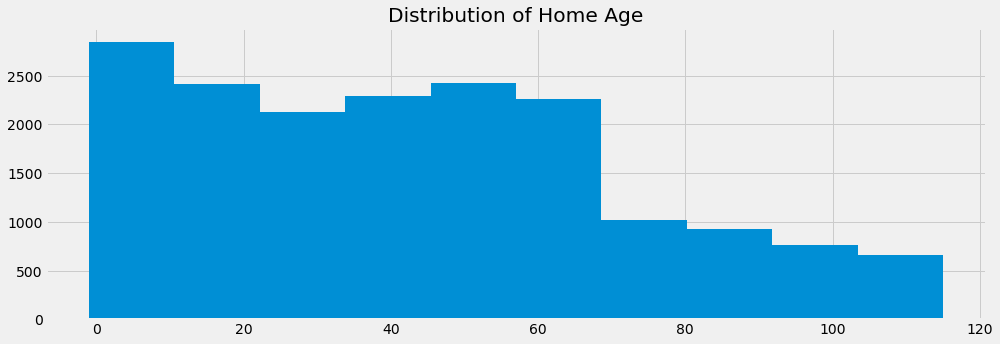

In [921]:
#create new column
df_scrub['home_age'] = df_scrub['yr_sold'] - df_scrub['yr_built']
#plot distribution
fig, ax = plt.subplots(figsize=(15,5))
df_scrub['home_age'].hist(ax=ax);
ax.set_title('Distribution of Home Age');

## Change Data Types

In [922]:
#check data types
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17755 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             17755 non-null  int64         
 1   date           17755 non-null  datetime64[ns]
 2   price          17755 non-null  float64       
 3   bedrooms       17755 non-null  int64         
 4   bathrooms      17755 non-null  float64       
 5   sqft_living    17755 non-null  int64         
 6   sqft_lot       17755 non-null  int64         
 7   floors         17755 non-null  float64       
 8   waterfront     15809 non-null  float64       
 9   view           17704 non-null  float64       
 10  condition      17755 non-null  int64         
 11  grade          17755 non-null  int64         
 12  sqft_above     17755 non-null  int64         
 13  sqft_basement  17755 non-null  int64         
 14  yr_built       17755 non-null  int64         
 15  yr_renovated   1775

>**OBSERVATIONS**
> - All data types seem good for the model

## Null Values

In [923]:
#check for null values
df_scrub.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1946
view               51
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
basement            0
renovated           0
yr_sold             0
home_age            0
dtype: int64

### `waterfront` Column

In [924]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)

0.0    15688
nan     1946
1.0      121
Name: waterfront, dtype: int64

> **OBSERVATIONS:**
> - `waterfront` has 11% null values.

> **ACTION**
> - I will explore how I can fill the nulls in the `waterfront` values

In [925]:
#correlation of waterfront
df_scrub.corr()['waterfront']

id              -0.0007271151406019631
price              0.28061779508670853
bedrooms        -0.0037972470805466155
bathrooms          0.06895849489521352
sqft_living        0.11490850577128048
sqft_lot           0.02592756366361523
floors            0.018991071659567576
waterfront                         1.0
view                0.4097734225678934
condition         0.017035059923196618
grade              0.08520732172037616
sqft_above         0.07953782583182091
sqft_basement      0.08954329499890055
yr_built         -0.023441718330979473
yr_renovated        0.0872436795030493
zipcode           0.029702414769883254
lat              -0.015771099373141872
long              -0.04205519654265491
sqft_living15      0.09252912301185473
sqft_lot15         0.02969156480538231
basement          0.042247678022296786
renovated          0.08763626037688341
yr_sold          -0.007725185091591844
home_age          0.023317154750412086
Name: waterfront, dtype: float64

> **OBSERVATIONS**
> - `waterfront` correlates most closely with `view` at a coefficient of 0.40

> **ACTIONS**
> - I will determine how i can utilize the `view` column to fill out the nulls in the `waterfall` column

In [926]:
#number of waterfront properties in each view category
df_scrub.groupby('view')['waterfront'].sum()

view
0.0     0.0
1.0     1.0
2.0     6.0
3.0    10.0
4.0   103.0
Name: waterfront, dtype: float64

> **OBSERVATIONS**
> - It seems that most of the waterfront homes also have a view ranking of 3 or 4

In [927]:
#there are 19 null values in waterfront with a view of 4
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,yr_sold,home_age
582,2998800125,2014-07-01,"730,000.0",2,2.25,2130,4920,1.5,nan,4.0,4,7,1530,600,1941,0.0,98116,47.573,-122.40899999999999,2130,4920,1,0,2014,73
1732,913000340,2015-01-02,"252,000.0",1,1.0,680,1638,1.0,nan,4.0,1,6,680,0,1910,"1,992.0",98116,47.5832,-122.399,1010,3621,0,1,2015,105
2563,7856400240,2015-02-11,"1,650,000.0",4,3.0,3900,9750,1.0,nan,4.0,5,10,2520,1380,1972,0.0,98006,47.5605,-122.15799999999999,3410,9450,1,0,2015,43
3825,8550001515,2014-10-01,"429,592.0",2,2.75,1992,10946,1.5,nan,4.0,5,6,1288,704,1903,0.0,98070,47.3551,-122.475,1110,8328,1,0,2014,111
4422,7781600100,2014-09-05,"1,340,000.0",3,2.75,2730,38869,1.5,nan,4.0,3,9,1940,790,1963,"2,001.0",98146,47.4857,-122.361,2630,28188,1,1,2014,51


In [928]:
#there are 54 null values in waterfront with a view of 3
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,yr_sold,home_age
60,1516000055,2014-12-10,"650,000.0",3,2.25,2150,21235,1.0,nan,3.0,4,8,1590,560,1959,0.0,98166,47.4336,-122.339,2570,18900,1,0,2014,55
216,46100204,2015-02-21,"1,510,000.0",5,3.0,3300,33474,1.0,nan,3.0,3,9,1870,1430,1957,"1,991.0",98040,47.5673,-122.21,3836,20953,1,1,2015,58
527,3225079035,2014-06-18,"1,600,000.0",6,5.0,6050,230652,2.0,nan,3.0,3,11,6050,0,2001,0.0,98024,47.6033,-121.943,4210,233971,0,0,2014,13
707,4022907770,2014-10-14,"550,000.0",4,1.75,2480,14782,1.0,nan,3.0,3,8,1460,1020,1958,0.0,98155,47.7646,-122.271,2910,10800,1,0,2014,56
830,2061100570,2015-02-10,"595,000.0",3,1.75,1910,5753,1.0,nan,3.0,3,8,1110,800,1941,0.0,98115,47.6898,-122.32700000000001,1630,5580,1,0,2015,74


> **ACTIONS**
> - Fill in the null waterfront value when the view is 3 or 4

In [929]:
#fill in null where view is 4
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4),['waterfront']] = 1

In [930]:
#fill in null where view is 3
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3),['waterfront']] = 1

In [931]:
#check the changes
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,yr_sold,home_age


In [932]:
#check the changes
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,yr_sold,home_age


In [933]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)/len(df_scrub)

0.0     0.8835820895522388
nan    0.10537876654463531
1.0   0.011039143903125881
Name: waterfront, dtype: float64

>**OBSERVATIONS**
> - The number of nulls in the `waterfront` column is still 10.5%

>**ACTIONS**
> - I will convert the rest of the nulls to zeros as they do not seem to have any other indicators of being a waterfront property

In [934]:
#convert waterfront null values to 0
df_scrub.loc[df_scrub['waterfront'].isna(),['waterfront']] = 0

In [935]:
#check waterfront values
df_scrub['waterfront'].value_counts(dropna=False)

0.0    17559
1.0      196
Name: waterfront, dtype: int64

In [936]:
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 17755 many rows.


### `view` Column

In [937]:
#view the values of the view column
df_scrub['view'].value_counts(dropna=False)

0.0    15972
2.0      792
3.0      403
1.0      277
4.0      260
nan       51
Name: view, dtype: int64

> **ACTION:**
> - I will drop the 39 null values

In [938]:
#drop rows
df_scrub.dropna(subset=['view'], inplace=True)
df_scrub['view'].isna().sum()

0

In [939]:
#check the view column
df_scrub['view'].value_counts(dropna=False)

0.0    15972
2.0      792
3.0      403
1.0      277
4.0      260
Name: view, dtype: int64

In [940]:
#recheck null values in dataframe
df_scrub.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
basement         0
renovated        0
yr_sold          0
home_age         0
dtype: int64

## Duplicates

### Duplicates for `id`

In [941]:
#check for duplicates
duplicate_id = df_scrub.loc[df_scrub.duplicated(subset='id', keep=False) == True].sort_values('id').head(50)
duplicate_id.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,yr_sold,home_age
2494,1000102,2014-09-16,"280,000.0",6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316,0,0,2014,23
2495,1000102,2015-04-22,"300,000.0",6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316,0,0,2015,24
11421,109200390,2014-08-20,"245,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956,0,0,2014,34
11422,109200390,2014-10-20,"250,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956,0,0,2014,34
7786,251300110,2015-01-14,"358,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,2510,0,1988,0.0,98003,47.3473,-122.314,1870,8017,0,0,2015,27


In [942]:
#check duplicates
df_scrub.loc[df_scrub['id'] == 4139480200]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,yr_sold,home_age
313,4139480200,2014-06-18,"1,380,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600,1997,0.0,98006,47.5503,-122.102,3860,11244,1,0,2014,17
314,4139480200,2014-12-09,"1,400,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600,1997,0.0,98006,47.5503,-122.102,3860,11244,1,0,2014,17


> **OBSERVATOINS**
> - Duplicates in the `id` column seem to represent multiple sales of the same house. 

> **ACTIONS**
> - I will consider these duplicates as separate homes and keep them in the dataset. The column `id` will be removed later.

## Column Drop

In [943]:
#look at columns
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'renovated',
       'yr_sold', 'home_age'],
      dtype='object')

### The `sqft_basement` Column

The `sqft_basement` column can be eliminated now that I have a column which represents whether or not a house has a basement.

In [944]:
#drop the sqft_basement column
df_scrub.drop(columns='sqft_basement', inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement', 'renovated', 'yr_sold',
       'home_age'],
      dtype='object')

### The `sqft_living15` and `sqft_lot15` Columns

The `sqft_living15` and `sqft_lot15` columns do not seem to be relevant for predicting home listing prices. I will remove these.

In [945]:
#drop columns
df_scrub.drop(columns=['sqft_living15','sqft_lot15'], inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'basement', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### `yr_renovated` Column

In [946]:
#drop the yr_renovated column
df_scrub.drop(columns='yr_renovated', inplace=True)

### `id` Column

In [947]:
#drop the id column
# df_scrub.drop(columns='id', inplace=True)

## State of Dataframe

In [948]:
#state of the dataframe
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1180,1955,98178,47.5112,-122.257,0,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,0,2015,28
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,3890,2001,98053,47.6561,-122.005,1,0,2014,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,2009,98103,47.6993,-122.346,0,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,2014,98146,47.5107,-122.36200000000001,0,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,2009,98144,47.5944,-122.29899999999999,0,0,2014,5
21595,291310100,2015-01-16,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,1600,2004,98027,47.5345,-122.069,0,0,2015,11


# Explore

I will now explore the dataset after initial scrubbing. I will investigate linearity and multicollinearity and correct any issues before modeling.

In [950]:
#create a copy of the scrub dataframe
df_explore = df_scrub.copy()
df_explore.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1180,1955,98178,47.5112,-122.257,0,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,0,2015,28
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,3890,2001,98053,47.6561,-122.005,1,0,2014,13


## Linearity

### `bedrooms`

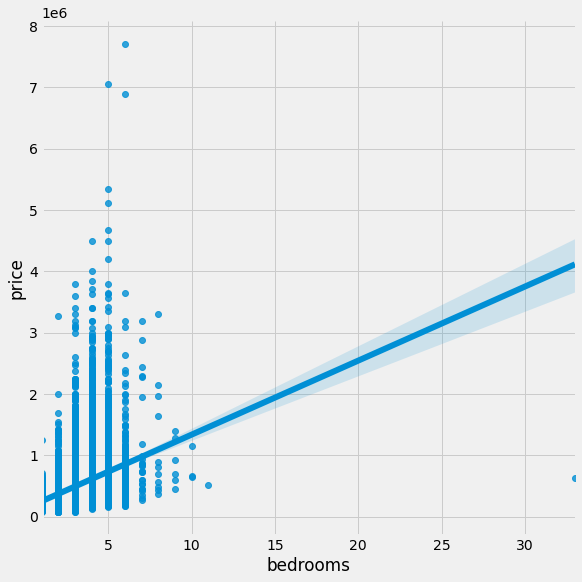

In [951]:
#check linearity between bedrooms and price
sns.lmplot(data=df_explore, x='bedrooms', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between the number of bedrooms and the price of the home for homes with a 1-5 bedrooms. Homes with 6+ bedrooms seem to be valued at a lower price. 
> - I notice some outliers that I will need to remove.

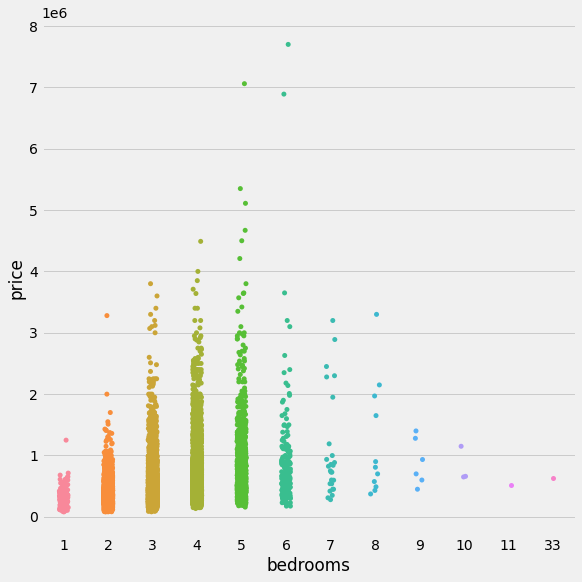

In [952]:
sns.catplot(data=df_explore, x='bedrooms', y='price', height=8)

### `bathrooms`

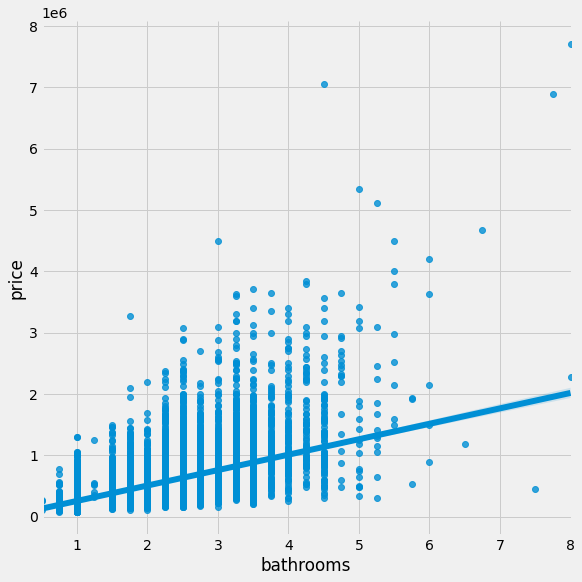

In [953]:
#check linearity between bathrooms and price
sns.lmplot(data=df_explore, x='bathrooms', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between `bathrooms` and `price`.

### `sqft_living`

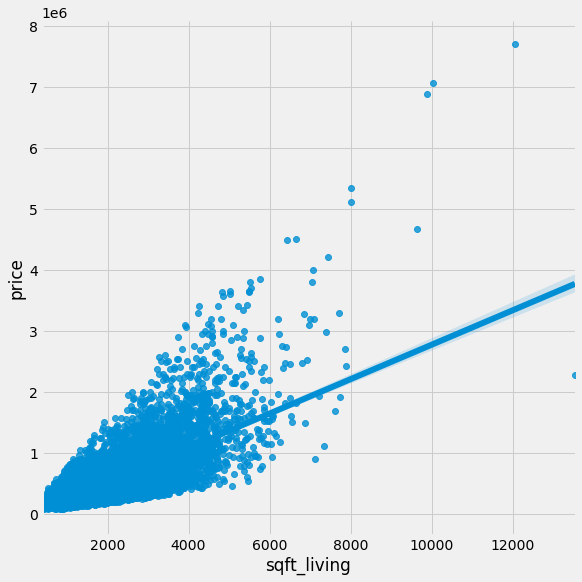

In [954]:
#check linearity between sqft_living and price
sns.lmplot(data=df_explore, x='sqft_living', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a strong linear relationship between `sqft_living` and `price`.

### `sqft_lot`

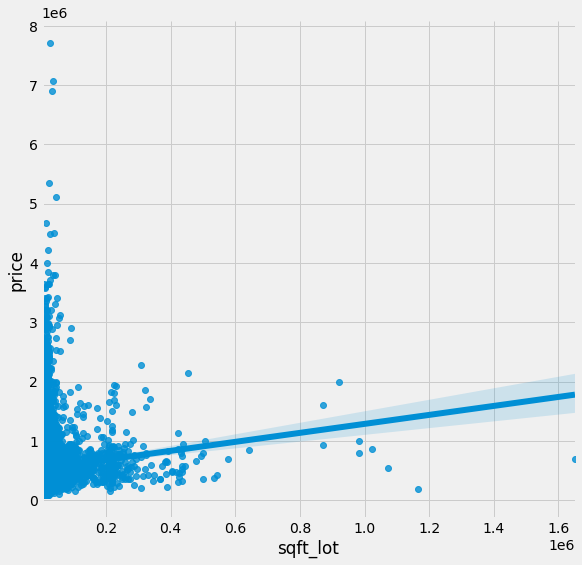

In [955]:
#check linearity between sqft_lot and price
sns.lmplot(data=df_explore, x='sqft_lot', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between `sqft_lot` and `price`. However, there seems to be 2 types of high value homes, 1) very small lot homes with high prices and 2) large lot homes with high prices

### `floors`

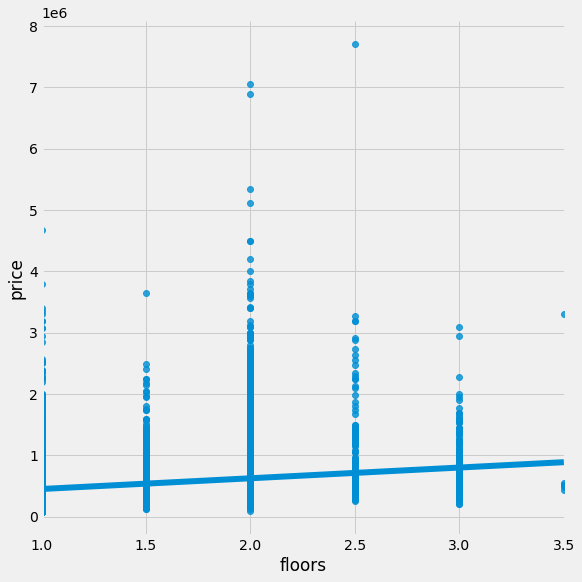

In [956]:
#check linearity between floors and price
sns.lmplot(data=df_explore, x='floors', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between `floors` and `price`.

### `grade`

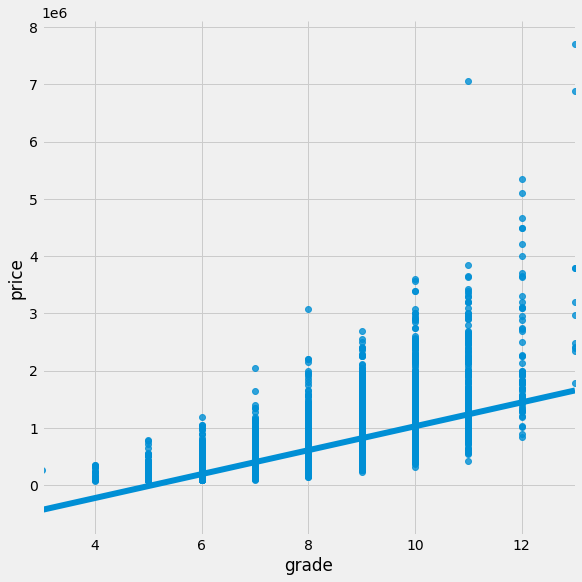

In [957]:
#check linearity between grade and price
sns.lmplot(data=df_explore, x='grade', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between `grade` and `price`.

### `condition`

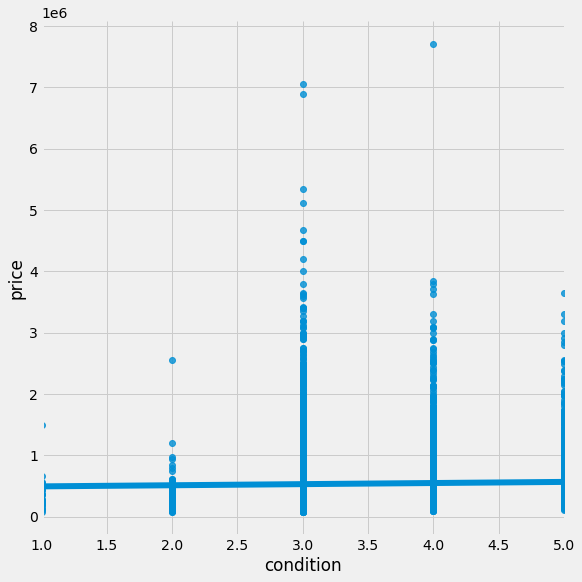

In [958]:
#check linearity between condition and price
sns.lmplot(data=df_explore, x='condition', y='price', height=8)

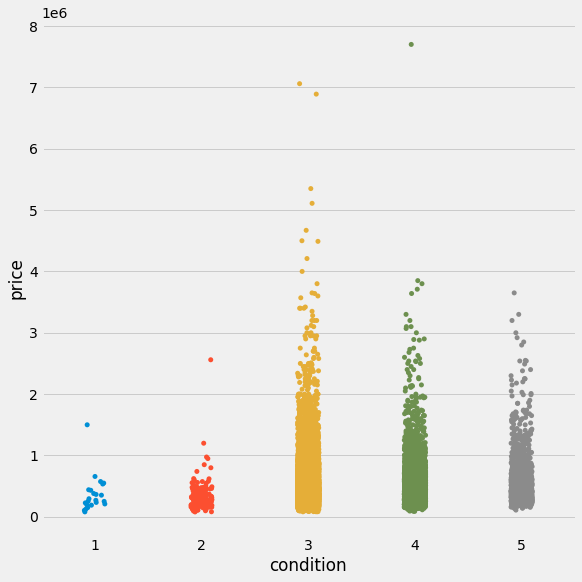

In [959]:
sns.catplot(data=df_explore, x='condition', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between `condition` and `price`, however, there seems to be a sweet spot around 3 i.e. not any additional value to condition 4 and 5. I will test this later

### `home_age`

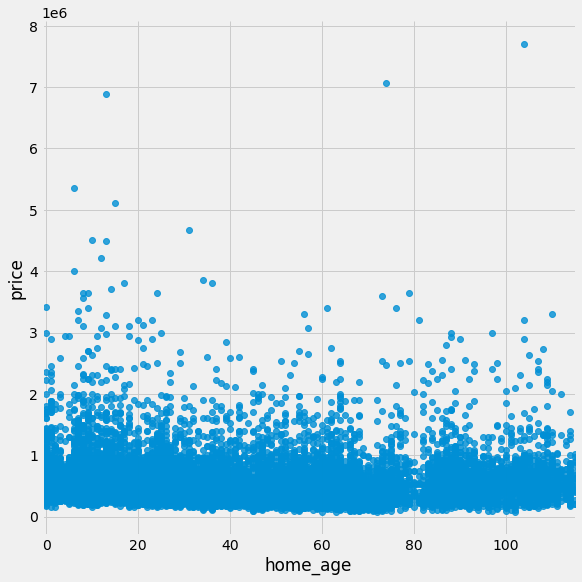

In [960]:
#check linearity between condition and price
sns.lmplot(data=df_explore, x='home_age', y='price', height=8)

> **OBSERVATIONS**
> - There seems to be a linear relationship between `home_age` and `price`, however, it seems like it is a neutral relationship.

## Multicollinearity

I want to check to see if the independent variables are truly independent from each other by checking for multicollinearity.

### Two Variable Multicollinearity Check

In [961]:
#remove lat and long columns
df_explore.drop(columns=['lat','long'], inplace=True)

<AxesSubplot:>

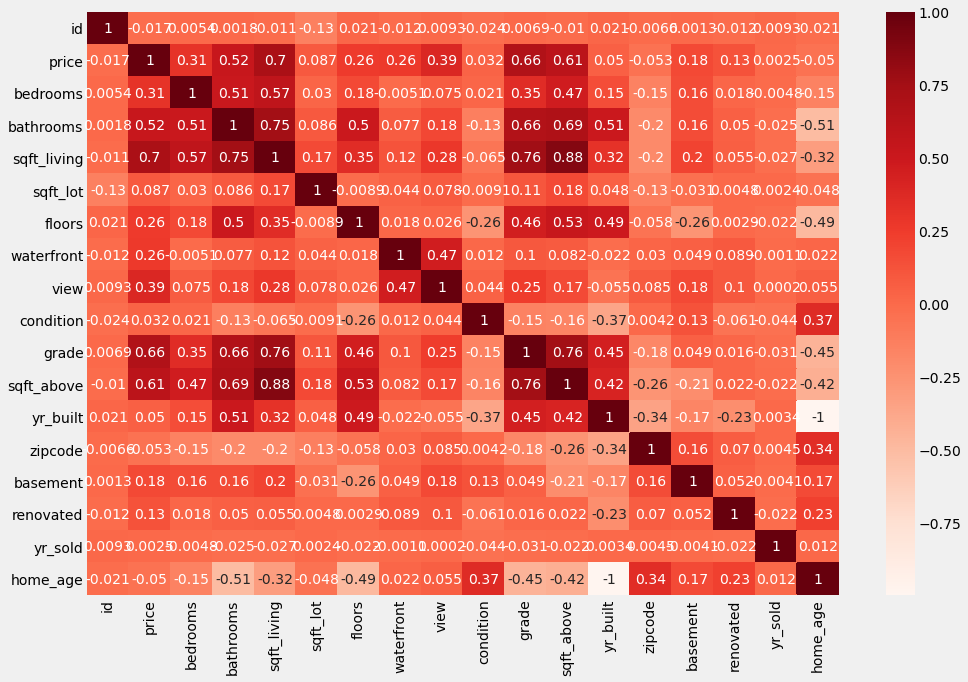

In [962]:
#create and plot correlations
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **ACTIONS**
> - Remove `sqft_above` as it correlates very closesly with `sqft_living`

In [963]:
#remove sqft_above
df_explore.drop(columns='sqft_above', inplace=True)

<AxesSubplot:>

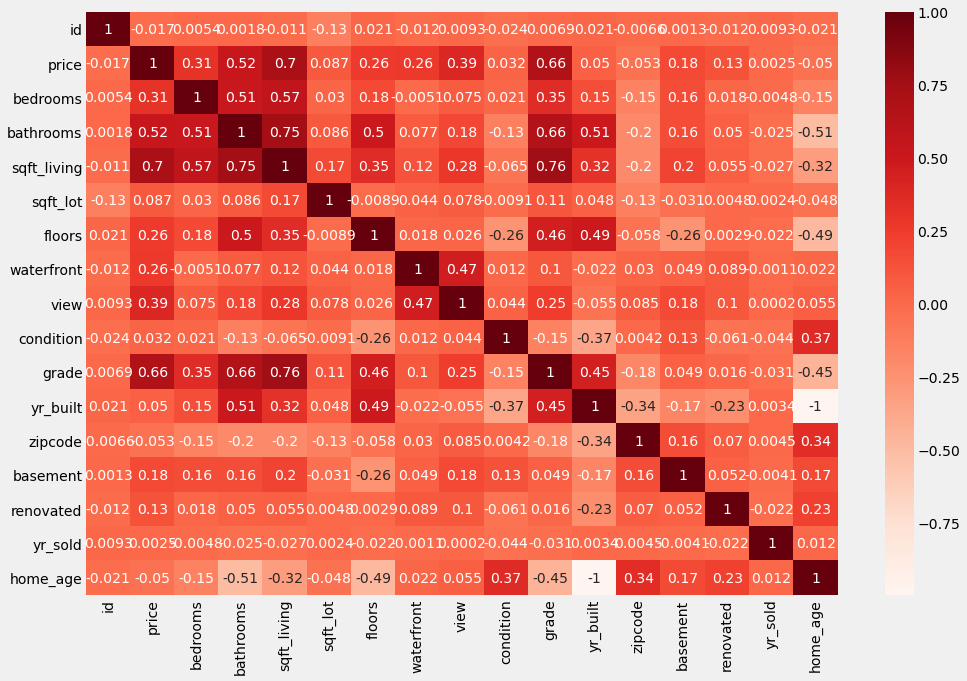

In [964]:
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **OBSERVATIONS**
> - There are no more variables which correlate above .75, therefore, variables are now considered independent.

## Outlier Removal

### `bedrooms`

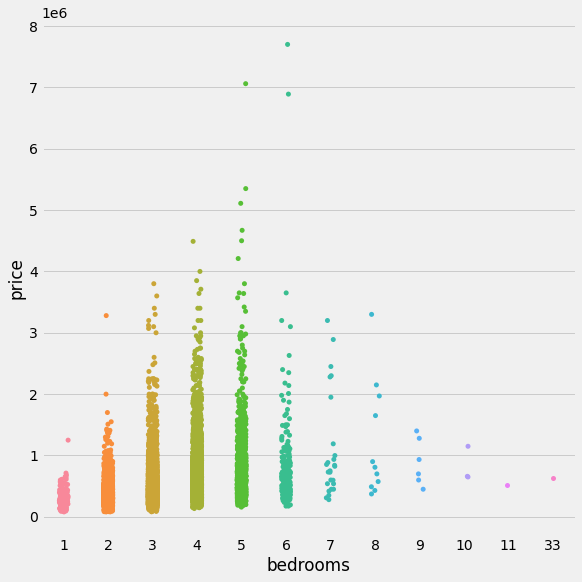

In [965]:
#check linearity between bedrooms and price
sns.catplot(data=df_explore, x='bedrooms', y='price', height=8)

> **OBSERVATIONS**
> - I believe a single model will struggle with accurately predicting homes with less than 6 homes with homes with 6 or more bedrooms. 

>**ACTIONS**
> - I will keep only homes with 5 or fewer bedrooms

In [966]:
#remove outliers
df_explore = df_explore.loc[df_explore['bedrooms'] <= 5]
len(df_explore)

17424

## Exploratory Questions

In [967]:
df_explore

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,basement,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1955,98178,0,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,1,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1965,98136,1,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1987,98074,0,0,2015,28
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,2001,98053,1,0,2014,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,2009,98103,0,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2014,98146,0,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,98144,0,0,2014,5
21595,291310100,2015-01-16,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,2004,98027,0,0,2015,11


Number of floors and price

home value by age

grade/ by age: are older homes constructed better

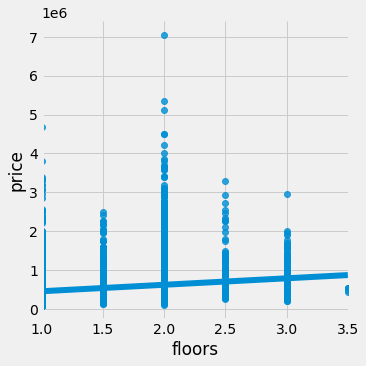

In [968]:
sns.lmplot(x='floors', y='price', data=df_explore)

average sales price by zipcode

average sales price by month_sold

correlation between view and price

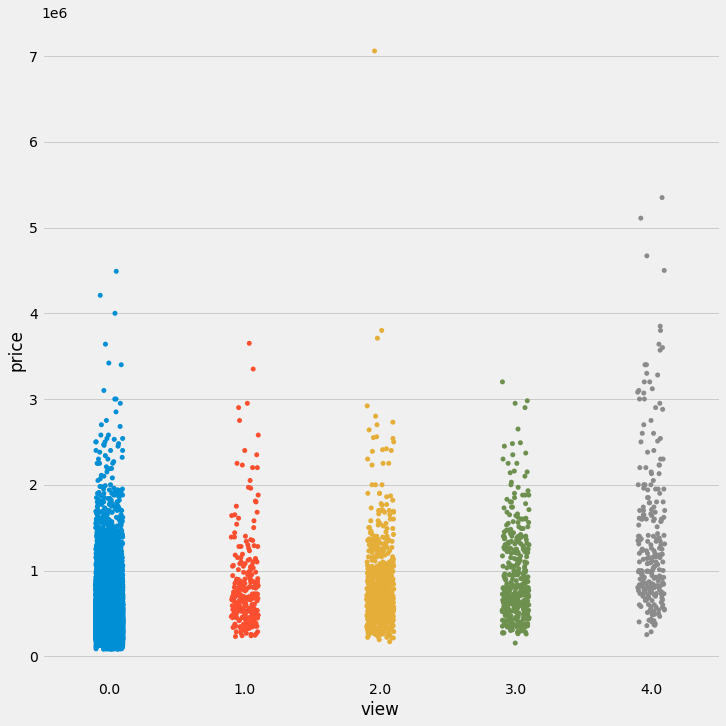

In [969]:
sns.catplot(data=df_explore, x='view', y='price', height=10)

count              17,424.0
mean      535,283.093721304
std     354,215.47262247116
min                80,000.0
25%               320,000.0
50%               450,000.0
75%               639,912.5
max             7,060,000.0
Name: price, dtype: float64

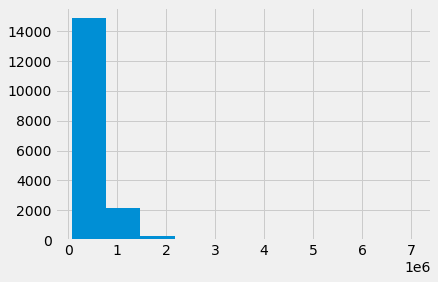

In [970]:
#distribution of home price
plt.hist(x=df_explore['price'])
df_explore['price'].describe()

# Modeling

In [971]:
#create a copy of the explore dataframe
df_model_base = df_explore.copy()
df_model_base

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,basement,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1955,98178,0,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,1,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1965,98136,1,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1987,98074,0,0,2015,28
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,2001,98053,1,0,2014,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,2009,98103,0,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2014,98146,0,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,98144,0,0,2014,5
21595,291310100,2015-01-16,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,2004,98027,0,0,2015,11


## Model Preprocessing

### Column Drop

#### `yr_built` Column

I will be removing `yr_built` as it is related to the new column I created named `home_age`

In [972]:
#drop the yr_built column
df_model_base.drop(columns='yr_built', inplace=True)

#### `date` Column

The `date` column represents the sale date which I do not think is relevant to the model's output since it is a datetime object.

In [973]:
#drop the date column
df_model_base.drop(columns='date', inplace=True)

#### `yr_sold` Column

The `yr_sold` column I created in order to create the `home_age` column. It is no longer needed.

In [974]:
#drop the yr_sold column
df_model_base.drop(columns='yr_sold', inplace=True)

## Model 1

- The data is now ready for the first model run. So far, I have taken the following steps:
    1. Removed irrelevant columns
    2. Removed some outliers in the raw data
    3. Removed columns due to 2-variable multicollinearity
    

### Model Creation

I will now create the initial model by copying the df_model_original dataframe.

In [975]:
#create a new model dataframe
df_model_1 = df_model_base.copy()
df_model_1

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,basement,renovated,home_age
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,98178,0,0,59
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,98125,1,1,63
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,98136,1,0,49
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,98074,0,0,28
5,7237550310,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,98053,1,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,98103,0,0,5
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,98146,0,0,1
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,98144,0,0,5
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,98027,0,0,11


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,basement,renovated,home_age
0,0.8828484125690885,"221,900.0",-0.39834574796776623,-1.4761162000798782,-0.9902889880360612,-0.2272499267847439,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,-0.5616717425173167,1.8754582283911905,-0.7960646341307491,-0.2070054668415114,0.5433732623906105
1,0.634316460595262,"538,000.0",-0.39834574796776623,0.19611041462902762,0.5685541395261385,-0.18943877133467454,0.9409004128365882,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,-0.5616717425173167,0.8843946473268516,1.2561073121770143,4.830513044675938,0.6797630490616083
3,-0.7302801625465221,"604,000.0",0.8097963429966133,1.1994463834543712,-0.1155424847997189,-0.24268789854513656,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,2.4391741473008666,-0.5616717425173167,1.0900870886798275,1.2561073121770143,-0.2070054668415114,0.20239879571311556
4,-0.9154281686948319,"510,000.0",-0.39834574796776623,-0.13833490831275352,-0.4295540500640469,-0.16953566312666063,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,0.2967991734144139,-0.06927030803694632,-0.7960646341307491,-0.2070054668415114,-0.5136475843096237
5,0.9204651900734983,"1,230,000.0",0.8097963429966133,3.206118321105058,3.76474328596662,2.0594699518161854,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,2.8722119212096056,-0.4619558778926278,1.2561073121770143,-0.2070054668415114,-1.025109284325866




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     2259.
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:36:16   Log-Likelihood:            -2.3834e+05
No. Observations:               17424   AIC:                         4.767e+05
Df Residuals:                   17409   BIC:                         4.768e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.353e+05   1599.544    334.647    

[('id', 1.0213400735082887),
 ('bedrooms', 1.6668281786739743),
 ('bathrooms', 3.3749897445134853),
 ('sqft_living', 4.246340989268888),
 ('sqft_lot', 1.0818017206084751),
 ('floors', 1.8478322170958004),
 ('waterfront', 1.2912793017186799),
 ('view', 1.452525216942928),
 ('condition', 1.2431817135939152),
 ('grade', 2.974725576449722),
 ('zipcode', 1.2818278739398086),
 ('basement', 1.365167751237008),
 ('renovated', 1.141200431277508),
 ('home_age', 2.2609063056361003)]



Normality Test Results


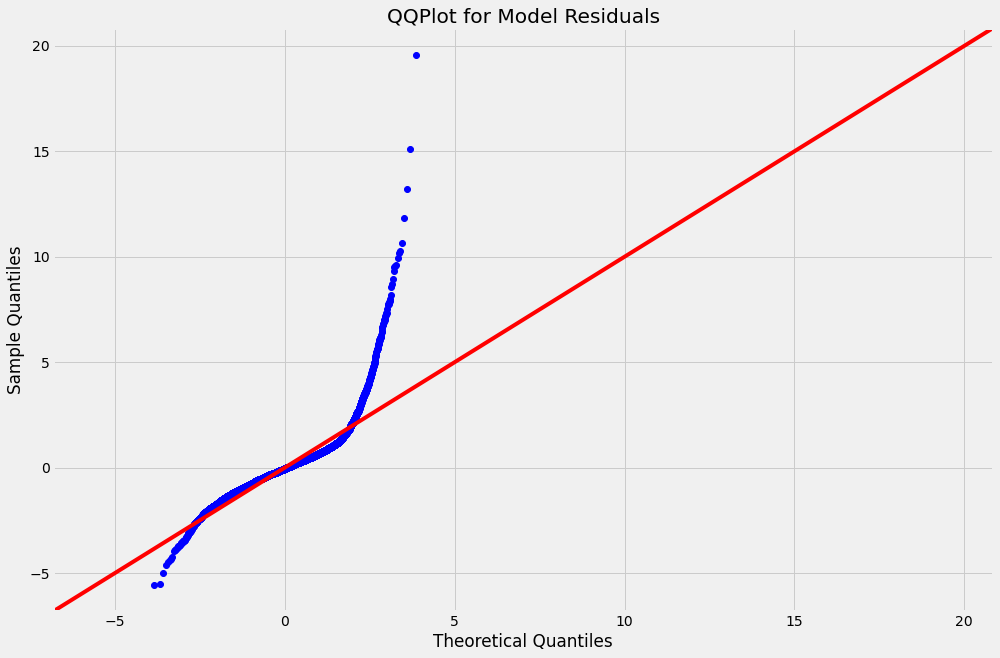



Homoscedasticity Test Results


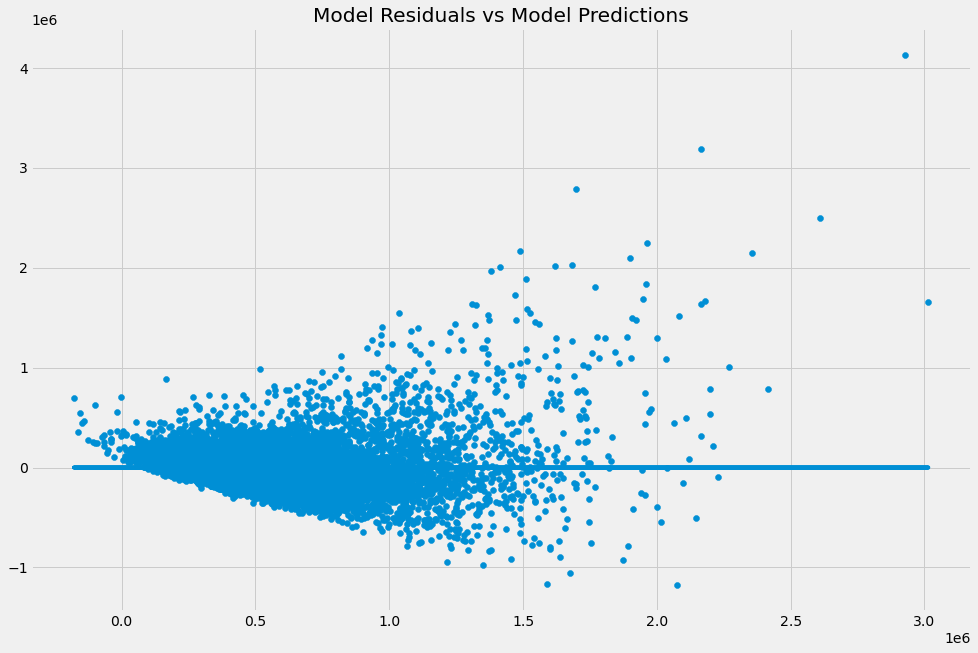

In [976]:
#define indpendent and dependent variables
x_cols = df_model_1.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
model_1 = fit_new_model(df_model_1, x_cols=x_cols, y_col=y_col, norm=True)

### Model Interpretation

>**OBSERVATOINS**
> - Adjusted R-Squared of 0.645
> - All features with significant p-values except for `zipcode` and `basement`
> - The most positively correlated features to price are `sqft_living`, `grade` and `home_age`
> - The most negatively correlated features to price are `bedrooms`, `zipcode` and `sqft_lot`
> - No multicollinearity found
> - Residuals not normal on the high end of the distribution
> - I am seeing heteroscedasticity along the bottom edge plus as the price gets higher

> **ACTIONS**
> - I will look at one hot encoding `zipcode`

### Model Tuning

#### OHE Columns

I will evaluate `zipcode` for OHE in order to better model this feature.

In [977]:
#check column names
df_model_base.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode',
       'basement', 'renovated', 'home_age'],
      dtype='object')

The number of rows removed is 0
count             17,424.0
mean    98,077.70443067035
std      53.47790092647879
min               98,001.0
25%               98,033.0
50%               98,065.0
75%               98,117.0
max               98,199.0
Name: zipcode, dtype: float64


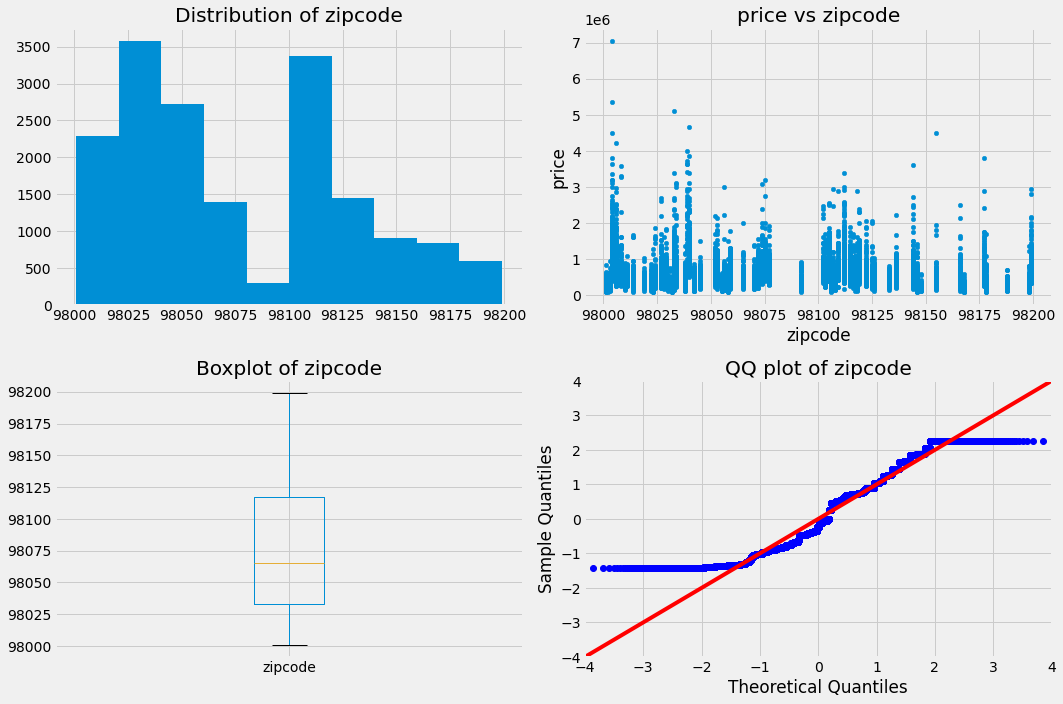

In [978]:
#investigate zipcode
get_plots(df_model_base,'zipcode')

> **OBSERVATIONS**
> - `zipcode` is categorical and needs to be hot-one encoded to improve the model.

In [979]:
#fit the data
cat_zipcode = ['zipcode']
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_model_base[cat_zipcode])

OneHotEncoder(drop='first', sparse=False)

In [980]:
#transform the data
ohe_vars = encoder.transform(df_model_base[cat_zipcode])
ohe_vars

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [981]:
#get the features
encoder.get_feature_names(cat_zipcode)

array(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [982]:
#convert to dataframe
df_cat_zipcode = pd.DataFrame(ohe_vars, columns=encoder.get_feature_names(cat_zipcode), index=df_model_base.index)
df_cat_zipcode

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [983]:
#concat original dataframe to zipcode dataframe and prepare for model number 2
df_model_base = pd.concat([df_model_base.drop('zipcode', axis=1), df_cat_zipcode], axis=1)
df_model_base

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7237550310,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,1,0,13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model 2

Going to refit the model with the new OHE `zipcode` columns

In [984]:
#copy the base model with the OHE column
df_model_2 = df_model_base.copy()
df_model_2

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7237550310,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,1,0,13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Creation

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.8828484125690885,"221,900.0",-0.39834574796776623,-1.4761162000798782,-0.9902889880360612,-0.2272499267847439,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,-0.5616717425173167,-0.7960646341307491,-0.2070054668415114,0.5433732623906105,-0.09596277715461661,...,-0.13699474409503512,-0.12802573696801406,-0.1536721864831851,-0.11229613905272431,-0.12940798863780384,-0.11590914317993417,-0.052005474771206914,-0.14233348461122858,-0.1091089822120815,-0.11359901159348759,-0.10748168344891193,9.075444548656513,-0.0789724526787843,-0.11666955126025881,-0.12138080225239621
1,0.634316460595262,"538,000.0",-0.39834574796776623,0.19611041462902762,0.5685541395261385,-0.18943877133467454,0.9409004128365882,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,-0.5616717425173167,1.2561073121770143,4.830513044675938,0.6797630490616083,-0.09596277715461661,...,7.299131178371918,-0.12802573696801406,-0.1536721864831851,-0.11229613905272431,-0.12940798863780384,-0.11590914317993417,-0.052005474771206914,-0.14233348461122858,-0.1091089822120815,-0.11359901159348759,-0.10748168344891193,-0.1101811159261813,-0.0789724526787843,-0.11666955126025881,-0.12138080225239621
3,-0.7302801625465221,"604,000.0",0.8097963429966133,1.1994463834543712,-0.1155424847997189,-0.24268789854513656,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,2.4391741473008666,-0.5616717425173167,1.2561073121770143,-0.2070054668415114,0.20239879571311556,-0.09596277715461661,...,-0.13699474409503512,-0.12802573696801406,-0.1536721864831851,8.904514583779848,-0.12940798863780384,-0.11590914317993417,-0.052005474771206914,-0.14233348461122858,-0.1091089822120815,-0.11359901159348759,-0.10748168344891193,-0.1101811159261813,-0.0789724526787843,-0.11666955126025881,-0.12138080225239621
4,-0.9154281686948319,"510,000.0",-0.39834574796776623,-0.13833490831275352,-0.4295540500640469,-0.16953566312666063,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,0.2967991734144139,-0.7960646341307491,-0.2070054668415114,-0.5136475843096237,-0.09596277715461661,...,-0.13699474409503512,-0.12802573696801406,-0.1536721864831851,-0.11229613905272431,-0.12940798863780384,-0.11590914317993417,-0.052005474771206914,-0.14233348461122858,-0.1091089822120815,-0.11359901159348759,-0.10748168344891193,-0.1101811159261813,-0.0789724526787843,-0.11666955126025881,-0.12138080225239621
5,0.9204651900734983,"1,230,000.0",0.8097963429966133,3.206118321105058,3.76474328596662,2.0594699518161854,-0.9172259379811286,-0.10527464284903644,-0.30183497242494395,-0.6284335139334112,2.8722119212096056,1.2561073121770143,-0.2070054668415114,-1.025109284325866,-0.09596277715461661,...,-0.13699474409503512,-0.12802573696801406,-0.1536721864831851,-0.11229613905272431,-0.12940798863780384,-0.11590914317993417,-0.052005474771206914,-0.14233348461122858,-0.1091089822120815,-0.11359901159348759,-0.10748168344891193,-0.1101811159261813,-0.0789724526787843,-0.11666955126025881,-0.12138080225239621




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     866.4
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:36:18   Log-Likelihood:            -2.3317e+05
No. Observations:               17424   AIC:                         4.665e+05
Df Residuals:                   17341   BIC:                         4.672e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.353e+05   1191.432    449.2

[('id', 1.0834535362593243),
 ('bedrooms', 1.7244537722421545),
 ('bathrooms', 3.435941872031066),
 ('sqft_living', 4.683443383200941),
 ('sqft_lot', 1.2322121483150708),
 ('floors', 2.289842006618728),
 ('waterfront', 1.3294194902621437),
 ('view', 1.533806270486079),
 ('condition', 1.3076715122111096),
 ('grade', 3.5115408207253074),
 ('basement', 1.5938097635591078),
 ('renovated', 1.1614879193137635),
 ('home_age', 3.047427865456321),
 ('zipcode_98002', 1.5562906145309634),
 ('zipcode_98003', 1.817135841038323),
 ('zipcode_98004', 1.9303298961397386),
 ('zipcode_98005', 1.488125201472997),
 ('zipcode_98006', 2.4280140044705063),
 ('zipcode_98007', 1.3882547183339577),
 ('zipcode_98008', 1.8199930713615209),
 ('zipcode_98010', 1.2936198949268545),
 ('zipcode_98011', 1.5409017185236387),
 ('zipcode_98014', 1.3929637372616426),
 ('zipcode_98019', 1.5091785905958066),
 ('zipcode_98022', 1.6879942791836529),
 ('zipcode_98023', 2.4108880060526277),
 ('zipcode_98024', 1.2335636855232983),



Normality Test Results


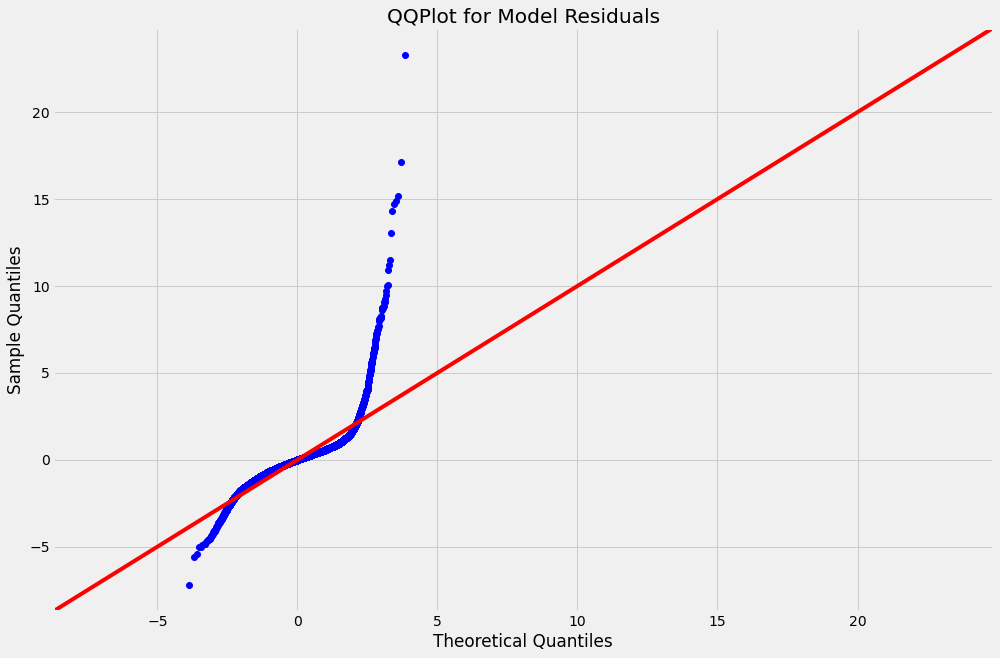



Homoscedasticity Test Results


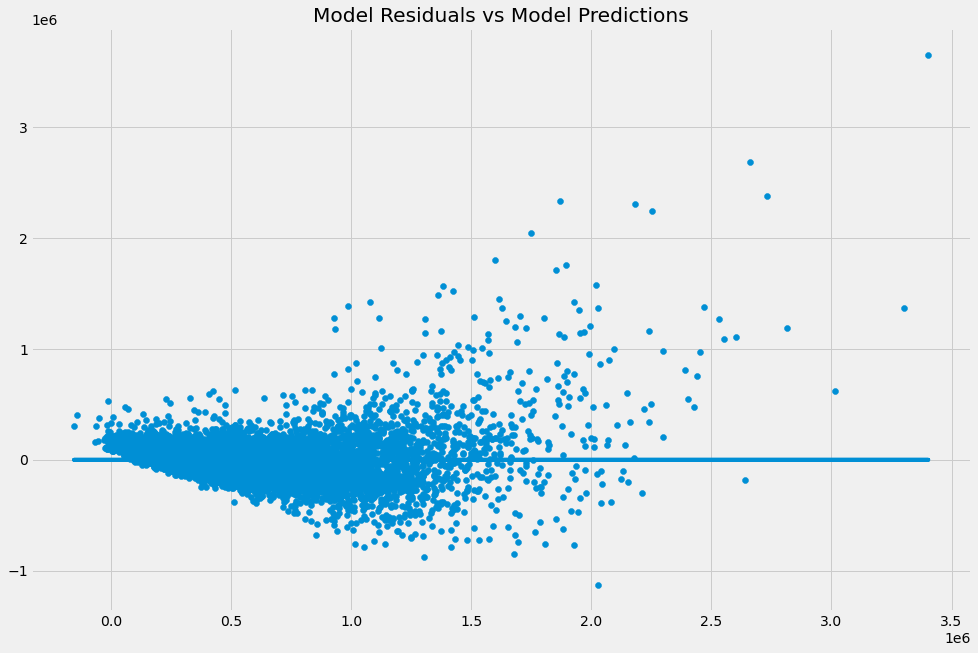

In [985]:
#define indpendent and dependent variables
x_cols = df_model_2.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
model_2 = fit_new_model(df_model_2, x_cols=x_cols, y_col=y_col, norm=True)

### Model Interpretation

>**OBSERVATOINS**
> - Adjusted R-Squared of 0.803
> - All features with significant p-values except for some zipcodes 
> - The most positively correlated features to price are `sqft_living`, `bathrooms`, `grade`  and `view`
> - The most negatively correlated features to price are `bedrooms`, `basement` and `floors`
> - QQ plot shows non-normality amongst the residuals
> - Homoscedasticity plot shows a larger spread of residuals in the upper range of `price`

>**ACTIONS**
> - I will proceed with removing outliers on `price` due to it not being modeled accurately on the high end

### Model Tuning

#### `price` Outlier Removal

I will investigate `price` for outliers.

The number of rows removed is 897
count              17,424.0
mean      535,283.093721304
std     354,215.47262247116
min                80,000.0
25%               320,000.0
50%               450,000.0
75%               639,912.5
max             7,060,000.0
Name: price, dtype: float64


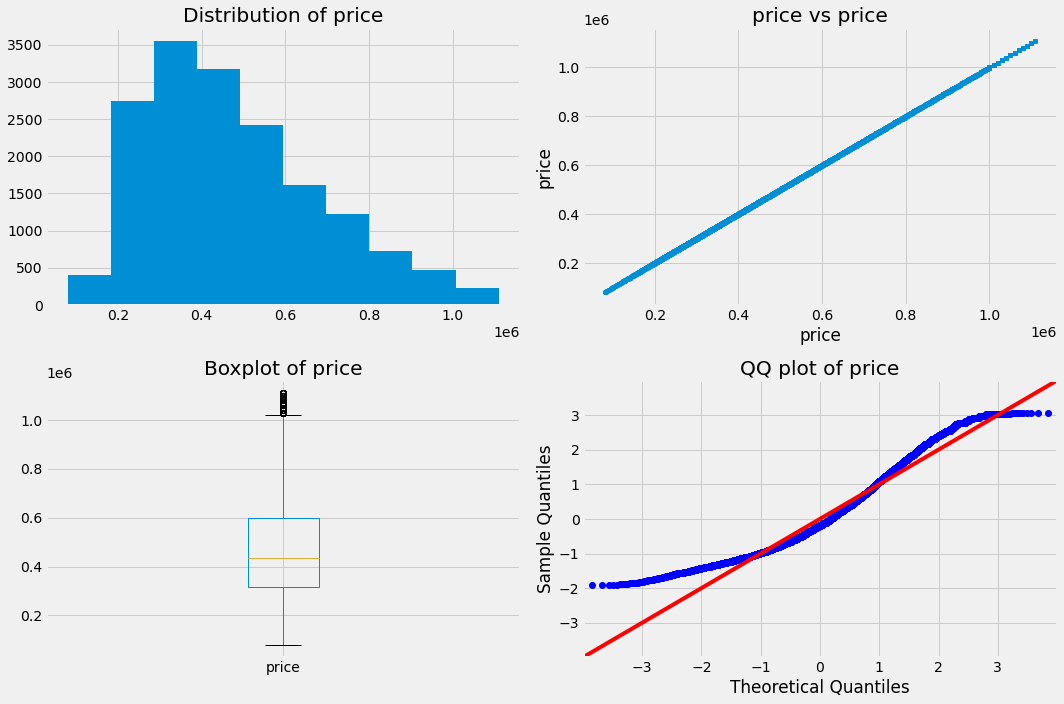

In [986]:
get_plots(df_model_base,'price',outlier='iqr')

> **OBSERVATIONS**
> - I will use iqr to remove outliers because there are a lot of outliers on the high side of `price`.

In [987]:
#create a copy of model_2 to set up model_3
df_model_3 = df_model_base.copy()
df_model_3

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7237550310,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,1,0,13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [988]:
#remove outliers based off iqr
df_model_base = outliers(df_model_base, 'price', 'iqr')
df_model_3 = df_model_base.copy()
df_model_3

There were 897 outliers removed.


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1321400060,"257,500.0",3,2.25,1715,6819,2.0,0.0,0.0,3,7,0,0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


count              16,527.0
mean    475,336.27548859443
std     206,876.38085246284
min                80,000.0
25%               315,000.0
50%               435,000.0
75%               600,000.0
max             1,110,000.0
Name: price, dtype: float64


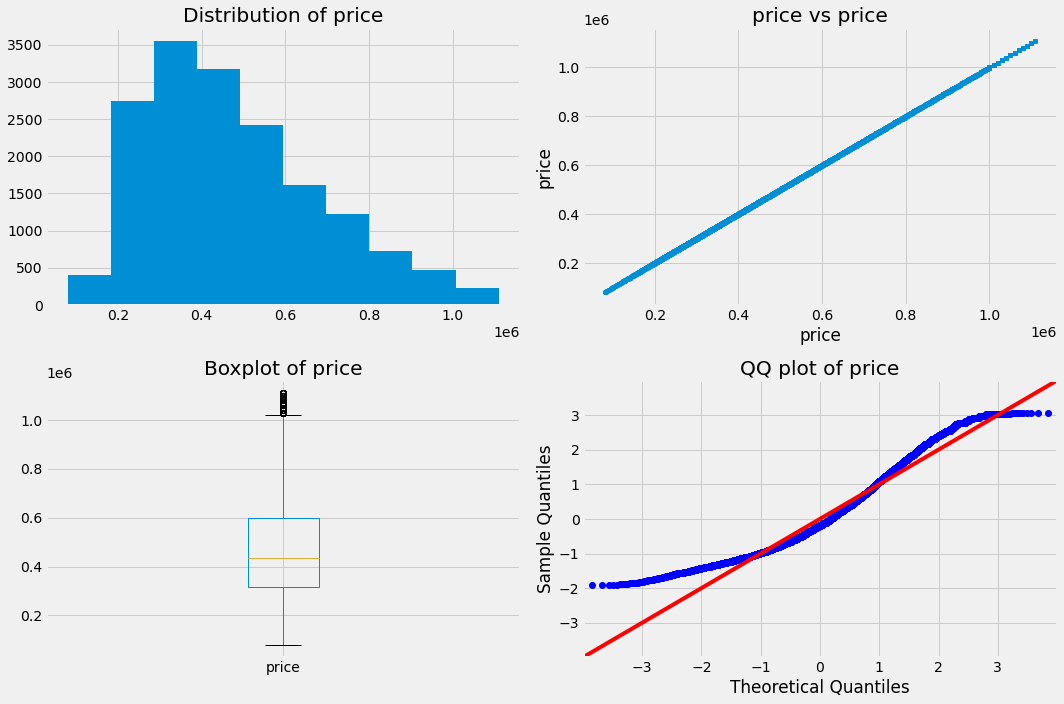

In [989]:
#recheck the price column
get_plots(df_model_3,'price',outlier='none')

## Model 3

In [990]:
#view model_3 dataframe
df_model_3

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1321400060,"257,500.0",3,2.25,1715,6819,2.0,0.0,0.0,3,7,0,0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Creation

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1321400060,"257,500.0",3,2.25,1715,6819,2.0,0.0,0.0,3,7,0,0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     965.2
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:36:56   Log-Likelihood:            -2.1119e+05
No. Observations:               16527   AIC:                         4.226e+05
Df Residuals:                   16444   BIC:                         4.232e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -3.93e+05   1.02e+04    -38.5

[('id', 3.8386107059154093),
 ('bedrooms', 28.362060210339447),
 ('bathrooms', 30.14626006281709),
 ('sqft_living', 25.77142768693474),
 ('sqft_lot', 1.3851007958023294),
 ('floors', 19.403106985417672),
 ('waterfront', 1.2358347919411972),
 ('view', 1.407347568829531),
 ('condition', 33.08495232146522),
 ('grade', 1.6130719349019806),
 ('basement', 2.5334248036821445),
 ('renovated', 1.183161594960379),
 ('home_age', 8.880441526783354),
 ('zipcode_98002', 1.419093828369418),
 ('zipcode_98003', 1.6643431421499228),
 ('zipcode_98004', 1.3906674893375095),
 ('zipcode_98005', 1.3920651697815962),
 ('zipcode_98006', 2.071703992348619),
 ('zipcode_98007', 1.327310232064803),
 ('zipcode_98008', 1.6654531195769249),
 ('zipcode_98010', 1.2329260394109751),
 ('zipcode_98011', 1.4253364469013172),
 ('zipcode_98014', 1.2850452961316758),
 ('zipcode_98019', 1.367884440158741),
 ('zipcode_98022', 1.5383659284960525),
 ('zipcode_98023', 2.168201346521042),
 ('zipcode_98024', 1.165989144678394),
 ('z



Normality Test Results


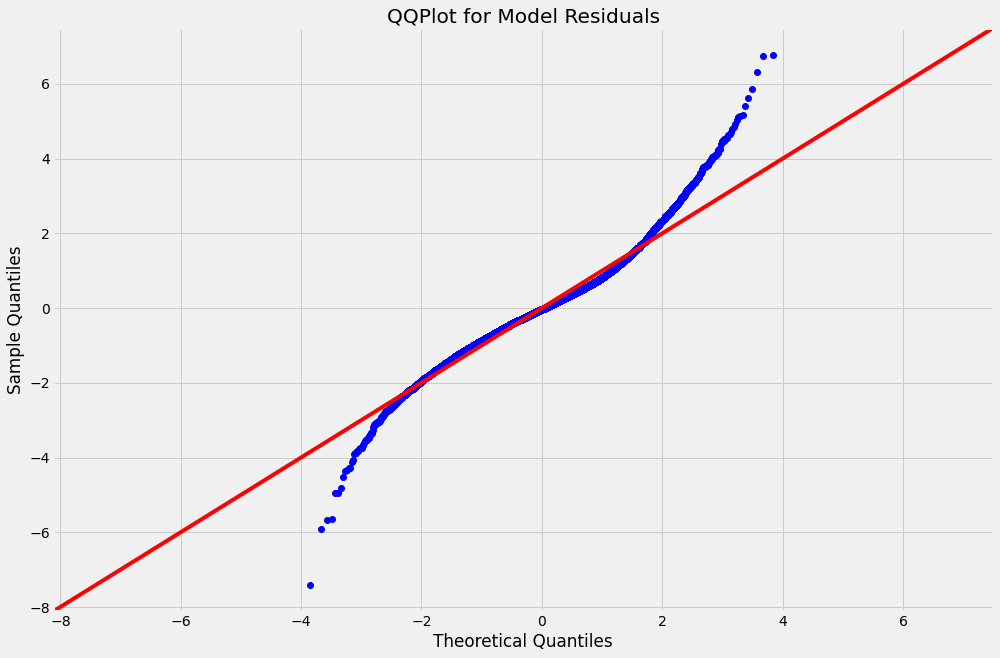



Homoscedasticity Test Results


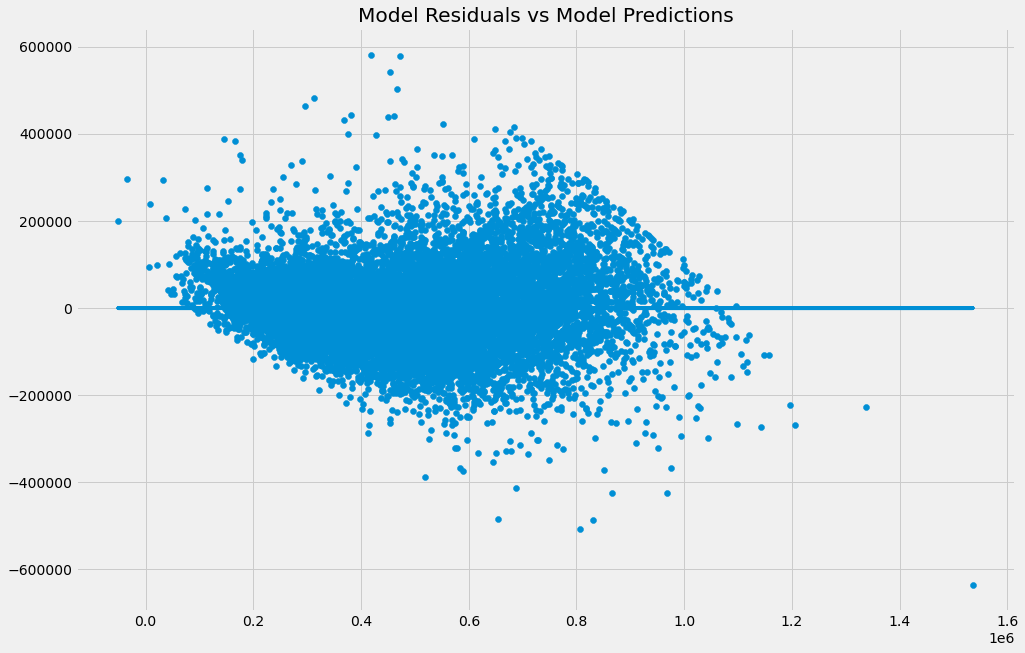

In [991]:
#define indpendent and dependent variables
x_cols = df_model_3.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
model_3 = fit_new_model(df_model_3, x_cols=x_cols, y_col=y_col, norm=False)

### Model Interpretation

>**OBSERVATIONS**
> - Adjusted R-Squared is now 0.837
> - All features with a significant p-value except for some zipcodes
> - Majority of zipcodes with significant p-values so I will keep them in
> - Coefficients of features are smaller in absolute than they were in model 2. I believe this is because of removing outliers in pricing
> - The distribution of the residuals is more normal
> - The variance in the residuals is more even throughout the prediction of price

> **ACTIONS**
> - Going to look through outliers of all columns and remove extreme values

### Model Tuning

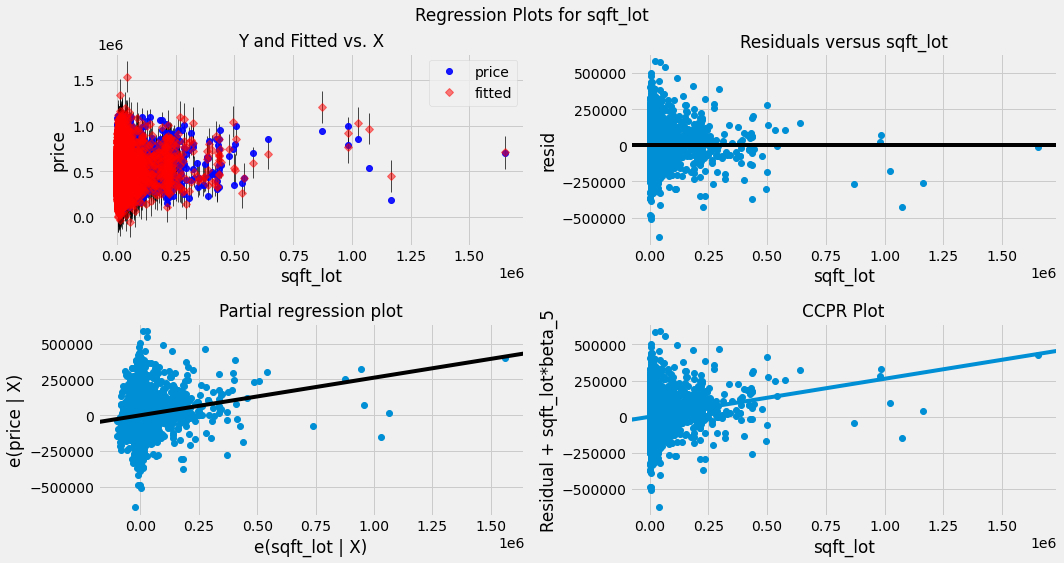

In [992]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_3,'sqft_lot', fig=fig)
plt.show()

>**OBSERVATIONS**
> - The residuals of `sqft_lot` show heteroscedasticity toward the lower side. This seems mostly skewed by the high priced homes which have very small lot sizes that may represent homes closer to the city.

> **ACTIONS**
> - Will remove the outliers of sqft_lot first and maybe and see if there is any improvement in the overall model.

#### `sqft_lot` Outlier Removal

I will investigate `sqft_lot` for outliers.

The number of rows removed is 1814
count              16,527.0
mean    14,748.061293640709
std      41,001.93285064867
min                   520.0
25%                 5,000.0
50%                 7,500.0
75%                10,283.5
max             1,651,359.0
Name: sqft_lot, dtype: float64


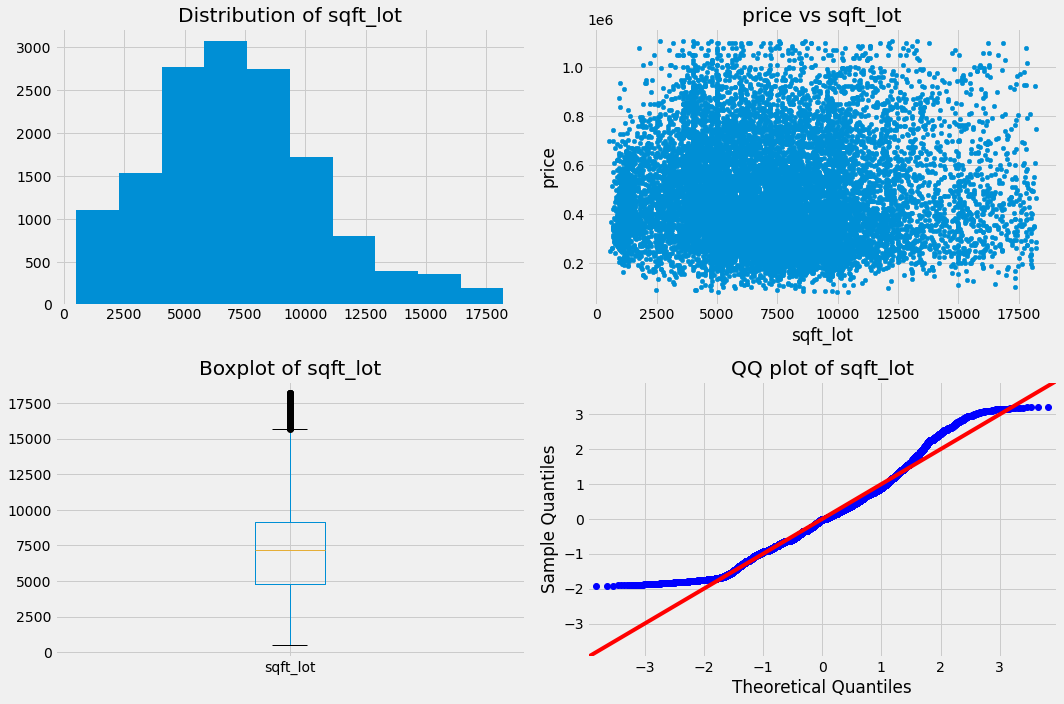

In [993]:
get_plots(df_model_base,'sqft_lot',outlier='iqr')

> **OBSERVATIONS**
> - I will use iqr to remove outliers of `sqft_lot`.

In [994]:
#create a copy of model_2 to set up model_3
df_model_4 = df_model_base.copy()
df_model_4

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1321400060,"257,500.0",3,2.25,1715,6819,2.0,0.0,0.0,3,7,0,0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [995]:
#remove outliers based off iqr
df_model_base = outliers(df_model_base, 'sqft_lot', 'iqr')
df_model_4 = df_model_base.copy()
df_model_4

There were 1814 outliers removed.


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1321400060,"257,500.0",3,2.25,1715,6819,2.0,0.0,0.0,3,7,0,0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


count             14,713.0
mean    7,188.183307279277
std     3,443.210270301906
min                  520.0
25%                4,800.0
50%                7,161.0
75%                9,163.0
max               18,200.0
Name: sqft_lot, dtype: float64


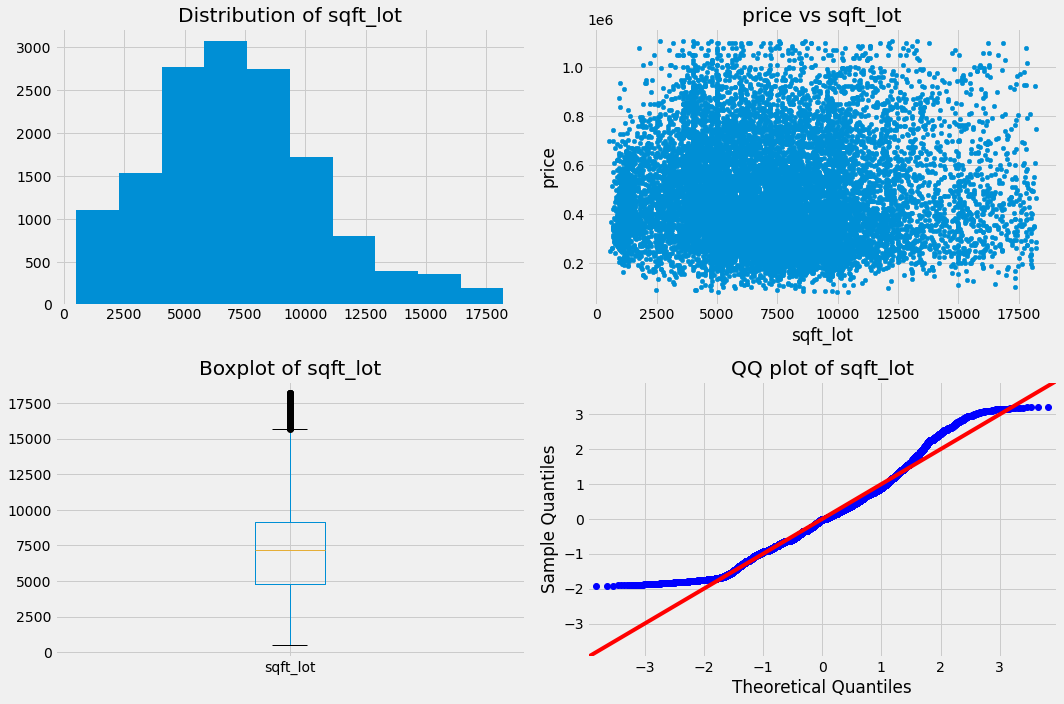

In [996]:
#recheck the sqft_lot column
get_plots(df_model_4,'sqft_lot',outlier='none')

## Model 4

In [997]:
#view model_3 dataframe
df_model_4

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1321400060,"257,500.0",3,2.25,1715,6819,2.0,0.0,0.0,3,7,0,0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Creation

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.8282064101723469,"221,900.0",-0.3393806244251373,-1.4785611049109237,-1.0026384463856017,-0.4467294142754769,-0.8800286019803105,-0.0612532627043511,-0.25314081404194727,-0.6287318497048804,-0.48307903473139885,-0.7829744567260256,-0.19235536441354206,0.5051469756323201,-0.10418559569784999,...,-0.14694473562458607,-0.13953242447854844,-0.16673666109309065,-0.1197451801064677,-0.13620525529191072,-0.12234634998878116,-0.0560007070694945,-0.15005222494338905,-0.10681999793358407,-0.11619162829400462,-0.10583944313193641,8.370933743329942,-0.0831363772462643,-0.12061810966114786,-0.12234634998878116
1,0.578929065638881,"538,000.0",-0.3393806244251373,0.33264793499935885,0.9343861946228085,0.015629801405071992,0.9655790982458043,-0.0612532627043511,-0.25314081404194727,-0.6287318497048804,-0.48307903473139885,1.2770940664874963,5.198357924379685,0.638862819314041,-0.10418559569784999,...,6.804816985418934,-0.13953242447854844,-0.16673666109309065,-0.1197451801064677,-0.13620525529191072,-0.12234634998878116,-0.0560007070694945,-0.15005222494338905,-0.10681999793358407,-0.11619162829400462,-0.10583944313193641,-0.11945286673578506,-0.0831363772462643,-0.12061810966114786,-0.12234634998878116
3,-0.7897602311479637,"604,000.0",0.88267202539548,1.4193733589455284,0.08432502123062846,-0.6355067322355,-0.8800286019803105,-0.0612532627043511,-0.25314081404194727,2.4455558554157273,-0.48307903473139885,1.2770940664874963,-0.19235536441354206,0.1708573664280181,-0.10418559569784999,...,-0.14694473562458607,-0.13953242447854844,-0.16673666109309065,8.350499218482279,-0.13620525529191072,-0.12234634998878116,-0.0560007070694945,-0.15005222494338905,-0.10681999793358407,-0.11619162829400462,-0.10583944313193641,-0.11945286673578506,-0.0831363772462643,-0.12061810966114786,-0.12234634998878116
4,-0.975463529865776,"510,000.0",-0.3393806244251373,-0.0295938729826977,-0.30586699278545415,0.2590073282519941,-0.8800286019803105,-0.0612532627043511,-0.25314081404194727,-0.6287318497048804,0.536947061422888,-0.7829744567260256,-0.19235536441354206,-0.5311508129010162,-0.10418559569784999,...,-0.14694473562458607,-0.13953242447854844,-0.16673666109309065,-0.1197451801064677,-0.13620525529191072,-0.12234634998878116,-0.0560007070694945,-0.15005222494338905,-0.10681999793358407,-0.11619162829400462,-0.10583944313193641,-0.11945286673578506,-0.0831363772462643,-0.12061810966114786,-0.12234634998878116
6,-1.1960907654624702,"257,500.0",-0.3393806244251373,0.33264793499935885,-0.25709299103344385,-0.10722066859045074,0.9655790982458043,-0.0612532627043511,-0.25314081404194727,-0.6287318497048804,-0.48307903473139885,-0.7829744567260256,-0.19235536441354206,-0.832011461184888,-0.10418559569784999,...,-0.14694473562458607,-0.13953242447854844,-0.16673666109309065,-0.1197451801064677,-0.13620525529191072,-0.12234634998878116,-0.0560007070694945,-0.15005222494338905,-0.10681999793358407,-0.11619162829400462,-0.10583944313193641,-0.11945286673578506,-0.0831363772462643,-0.12061810966114786,-0.12234634998878116




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     917.5
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:37:34   Log-Likelihood:            -1.8736e+05
No. Observations:               14713   AIC:                         3.749e+05
Df Residuals:                   14630   BIC:                         3.755e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.655e+05    678.528    686.0

[('id', 1.0931044712294868),
 ('bedrooms', 1.8058458464281073),
 ('bathrooms', 3.15627134260688),
 ('sqft_living', 4.012982093309035),
 ('sqft_lot', 2.099104917465709),
 ('floors', 2.6802437562825),
 ('waterfront', 1.1845640192639595),
 ('view', 1.2903059434072561),
 ('condition', 1.317771268487825),
 ('grade', 2.924861841613486),
 ('basement', 1.6502922583865807),
 ('renovated', 1.1433315999438094),
 ('home_age', 3.3767651930569085),
 ('zipcode_98002', 1.6617776705530964),
 ('zipcode_98003', 1.9232667769932579),
 ('zipcode_98004', 1.4945911714144953),
 ('zipcode_98005', 1.39038535612296),
 ('zipcode_98006', 2.26556110914219),
 ('zipcode_98007', 1.4282598314680388),
 ('zipcode_98008', 1.8869832096688899),
 ('zipcode_98010', 1.1573176184478104),
 ('zipcode_98011', 1.5847508002916433),
 ('zipcode_98014', 1.1687863145496675),
 ('zipcode_98019', 1.4348173077858632),
 ('zipcode_98022', 1.486684078125393),
 ('zipcode_98023', 2.563093239841401),
 ('zipcode_98024', 1.093995706731941),
 ('zipco



Normality Test Results


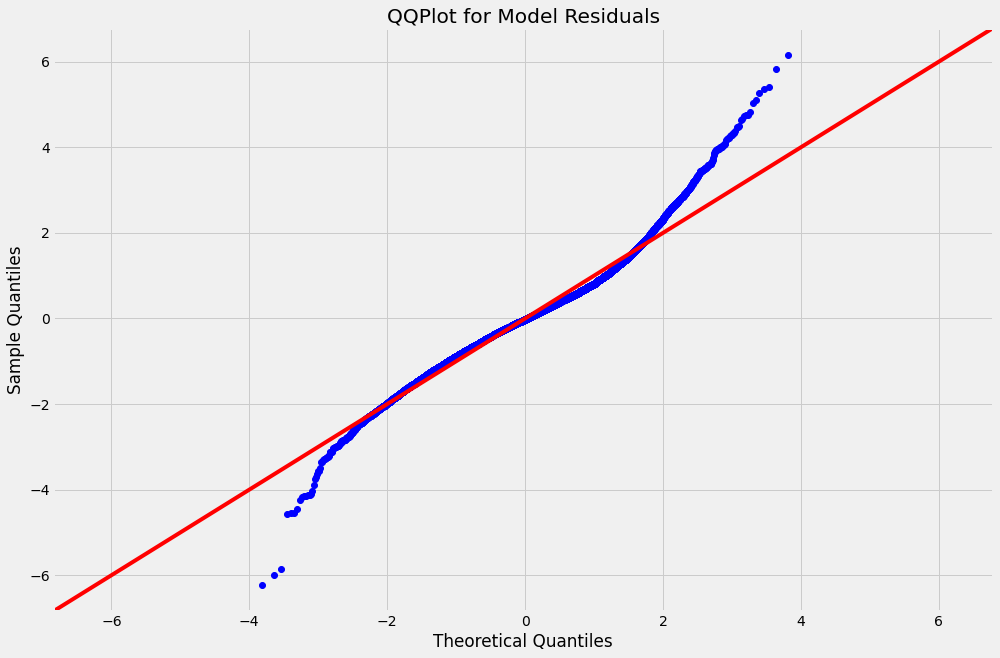



Homoscedasticity Test Results


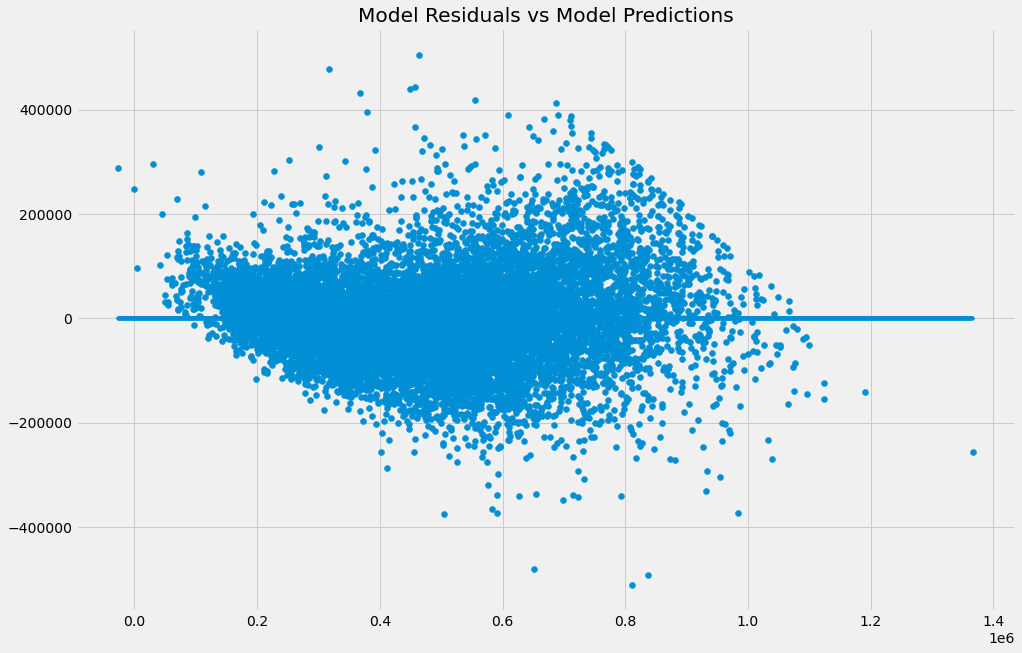

In [998]:
#define indpendent and dependent variables
x_cols = df_model_4.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
model_4 = fit_new_model(df_model_4, x_cols=x_cols, y_col=y_col, norm=True)

In [999]:
coefficients_df = pd.DataFrame(model_4.params[:13], columns=['Coefficient'])
coefficients_df.drop('Intercept', inplace=True)

In [1000]:
coefficients_df.to_csv(r'Model Coefficients (scaled) for Tableau.csv', header=True)

<AxesSubplot:xlabel='Coefficient'>

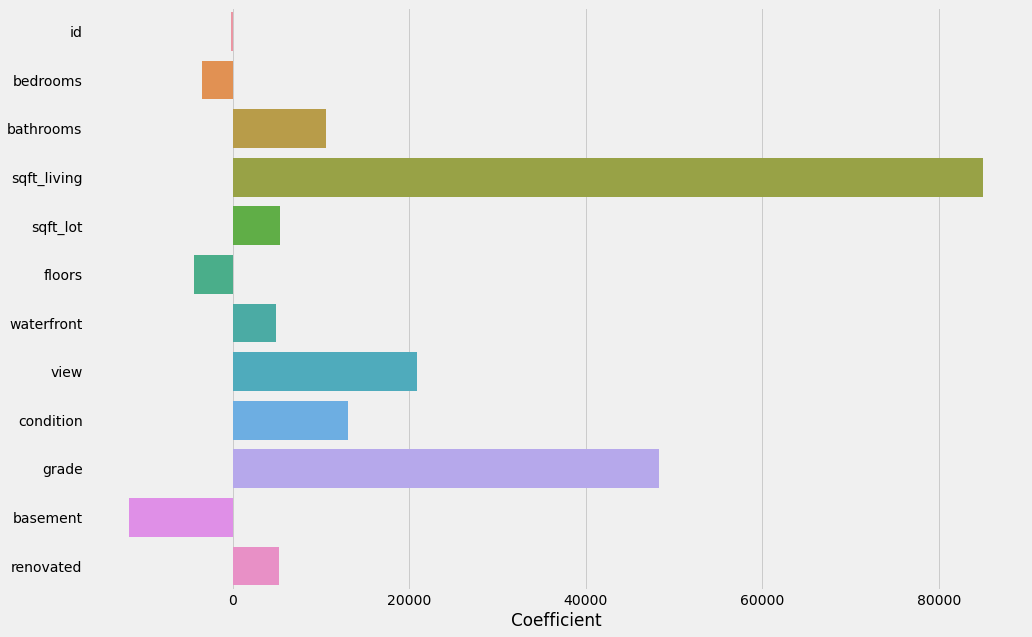

In [1001]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data = coefficients_df, y=coefficients_df.index, x='Coefficient', ax=ax, orient='h')


### Model Interpretation

# Appendix

## Dataset for Tableau

In [1002]:
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1180,1955,98178,47.5112,-122.257,0,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,0,2015,28
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,0.0,3,11,3890,2001,98053,47.6561,-122.005,1,0,2014,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,2009,98103,47.6993,-122.346,0,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,2014,98146,47.5107,-122.36200000000001,0,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,2009,98144,47.5944,-122.29899999999999,0,0,2014,5
21595,291310100,2015-01-16,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,1600,2004,98027,47.5345,-122.069,0,0,2015,11


In [1003]:
#remove outliers
df_scrub = df_scrub.loc[df_scrub['bedrooms'] <= 5]

In [1004]:
#remove outliers based off iqr
df_scrub = outliers(df_scrub, 'price', 'iqr')

There were 897 outliers removed.


In [1005]:
#remove outliers based off iqr
df_scrub = outliers(df_scrub, 'sqft_lot', 'iqr')

There were 1814 outliers removed.


In [1008]:
len(df_scrub)

14713

In [1007]:
df_scrub.to_csv(r'Scrubbed Housing Data for Tableau.csv',index=False, header=True)

In [ ]:
df_scrub['']